# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



## Data Understanding

### Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools
import copy
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas_profiling import ProfileReport
from kPOD import k_pod
from sklearn.metrics.pairwise import pairwise_distances

from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
import optuna
from tensorflow.keras.losses import BinaryCrossentropy
import category_encoders
try:
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
except:
    !pip install autoimpute
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
clear_output();
%matplotlib inline


In [2]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [3]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [4]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

#### Random seed

In [5]:
random_seed=42
np.random.seed(random_seed)

### Data Describe and EDA

#### Pandas Profiling

In [6]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

#### Univariate analysis

Including Data re-expression, type casting, Outliers

In [7]:
def EDA_plot1(df,column):  
    df[column].value_counts(sort=False)[::-1].plot(kind='bar',title=column+'counts')
    pd.crosstab(df[column],df['vacc_h1n1_f'],normalize='columns').plot(kind='bar',title=column + ' distribution by target')

In [8]:
type_feature={}

##### (target) vacc_h1n1_f

- Description : Whether respondent received H1N1 flu vaccine.

<AxesSubplot:title={'center':'vacc_h1n1_f'}>

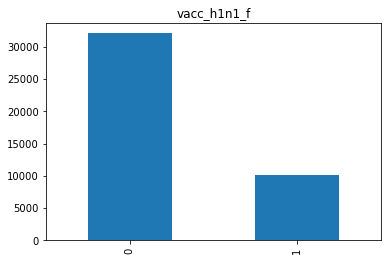

In [9]:
df['vacc_h1n1_f'].value_counts().plot(kind='bar',title='vacc_h1n1_f')

- Note : Nominal, Imbalanced Data

In [10]:
type_feature['vacc_h1n1_f'] = 'bool'

##### vacc_seas_f

- Description : Whether respondent received seasonal flu vaccine.

<AxesSubplot:title={'center':'vacc_seas_f'}>

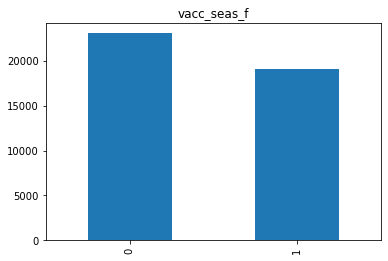

In [11]:
df['vacc_seas_f'].value_counts().plot(kind='bar',title='vacc_seas_f')

- Note : boolean, Imbalanced Data, dependent variable

In [12]:
type_feature['vacc_seas_f'] = 'bool'

##### h1n1_concern 

- Description : Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.   

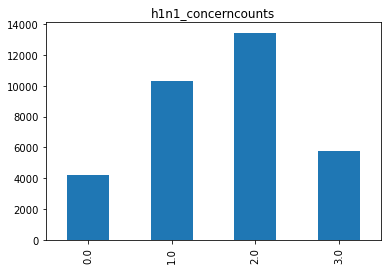

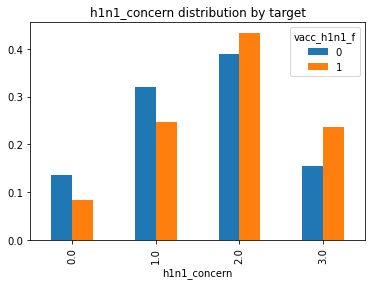

In [13]:
EDA_plot1(df,'h1n1_concern')

- Note : ordinal type

In [14]:
type_feature['h1n1_concern'] = 'ordinal'

##### h1n1_knowledge

- Description : Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   

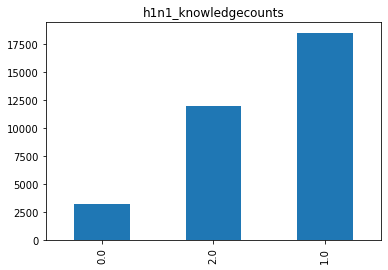

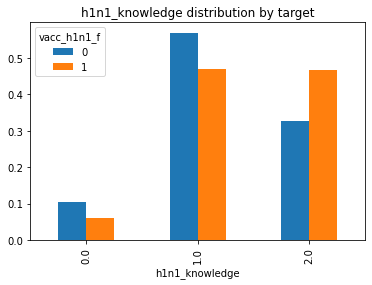

In [15]:
EDA_plot1(df,'h1n1_knowledge')

- Note : Disordered

In [16]:
type_feature['h1n1_knowledge'] = 'ordinal'

##### behavioral_antiviral_meds

- Description : Has taken antiviral medications.

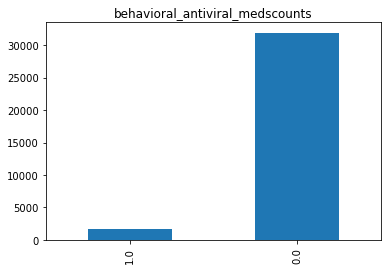

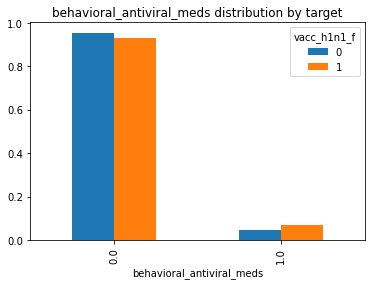

In [17]:
EDA_plot1(df,'behavioral_antiviral_meds')

- Note : boolean

In [18]:
type_feature['behavioral_antiviral_meds'] = 'bool'

##### behavioral_avoidance

- Description : Has avoided close contact with others with flu-like symptoms.

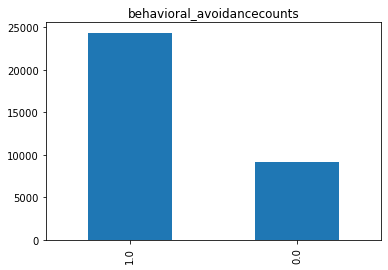

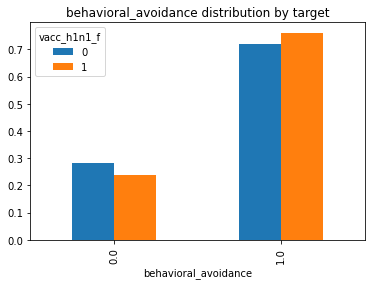

In [19]:
EDA_plot1(df,'behavioral_avoidance')

- Note : boolean

In [20]:
type_feature['behavioral_avoidance'] = 'bool'

##### behavioral_face_mask

- Description : Has bought a face mask.

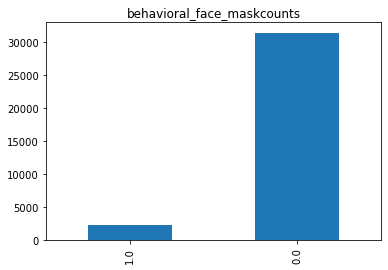

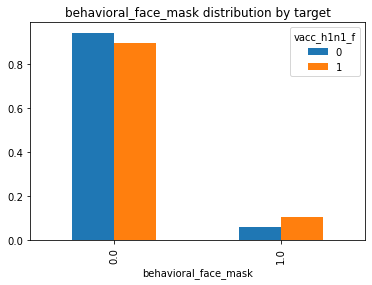

In [21]:
EDA_plot1(df,'behavioral_face_mask')

- Note : boolean

In [22]:
type_feature['behavioral_face_mask'] = 'bool'

##### behavioral_wash_hands

- Description : Has frequently washed hands or used hand sanitizer.

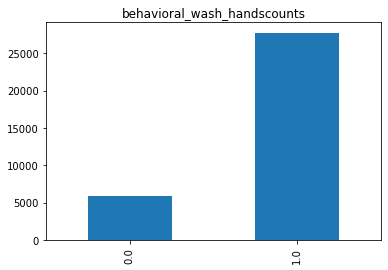

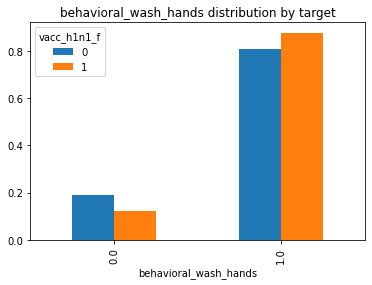

In [23]:
EDA_plot1(df,'behavioral_wash_hands')

- Note : boolean

In [24]:
type_feature['behavioral_wash_hands'] = 'bool'

##### behavioral_large_gatherings

- Description : Has reduced time at large gatherings.

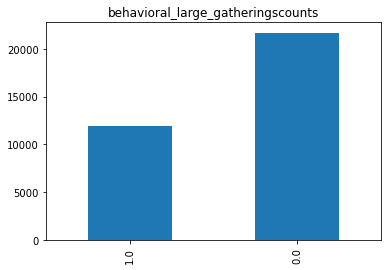

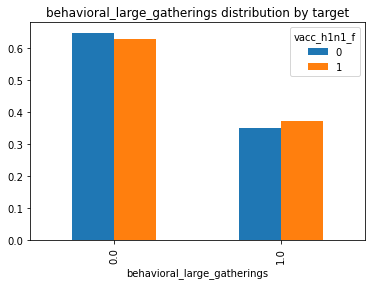

In [25]:
EDA_plot1(df,'behavioral_large_gatherings')

- Note : boolean

In [26]:
type_feature['behavioral_large_gatherings'] = 'bool'

##### behavioral_outside_home

- Description : Has reduced contact with people outside of own household.

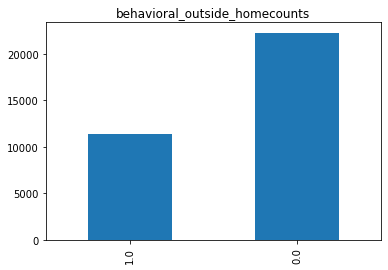

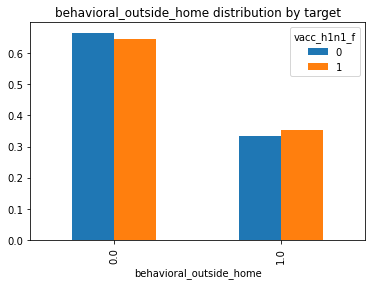

In [27]:
EDA_plot1(df,'behavioral_outside_home')

- Note : boolean

In [28]:
type_feature['behavioral_outside_home'] = 'bool'

##### behavioral_touch_face

- Description : Has avoided touching eyes, nose, or mouth.

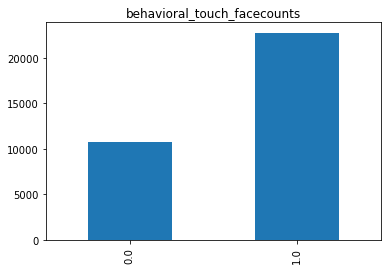

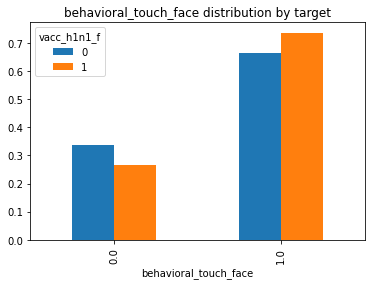

In [29]:
EDA_plot1(df,'behavioral_touch_face')

- Note : boolean

In [30]:
type_feature['behavioral_touch_face'] = 'bool'

##### doctor_recc_h1n1

- Description : H1N1 flu vaccine was recommended by doctor.

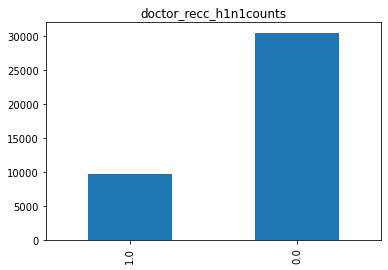

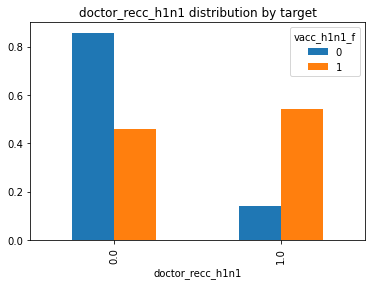

In [31]:
EDA_plot1(df,'doctor_recc_h1n1')

In [32]:
type_feature['doctor_recc_h1n1'] = 'bool'

- Note : boolean, significant difference

##### doctor_recc_seasonal

- Description : Seasonal flu vaccine was recommended by doctor.

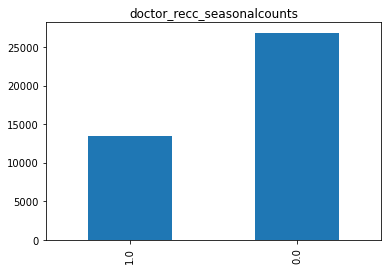

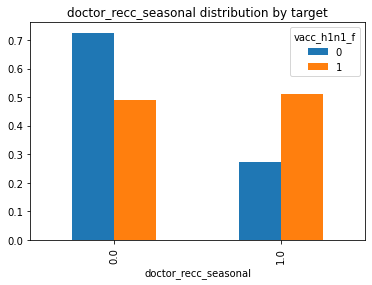

In [33]:
EDA_plot1(df,'doctor_recc_seasonal')

- Note : boolean, seasonal, significant difference

In [34]:
type_feature['doctor_recc_seasonal'] = 'bool'

##### chronic_med_condition

- Description : Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. 

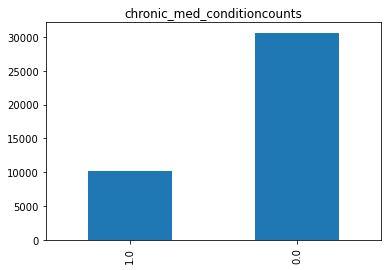

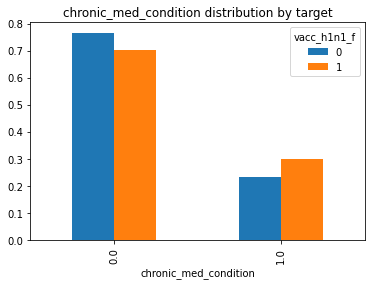

In [35]:
EDA_plot1(df,'chronic_med_condition')

- Note : boolean

In [36]:
type_feature['chronic_med_condition'] = 'bool'

##### child_under_6_months

- Description : Has regular close contact with a child under the age of six months.

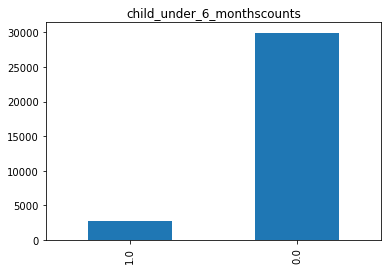

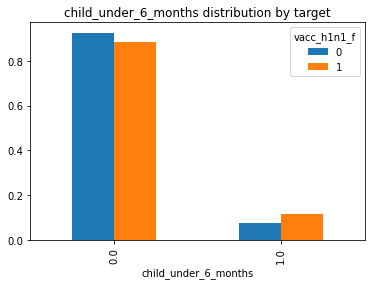

In [37]:
EDA_plot1(df,'child_under_6_months')

- Note : boolean

In [38]:
type_feature['child_under_6_months'] = 'bool'

##### health_insurance

- Description : Has health insurance.

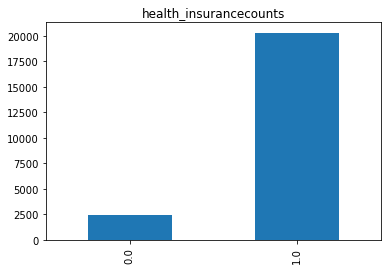

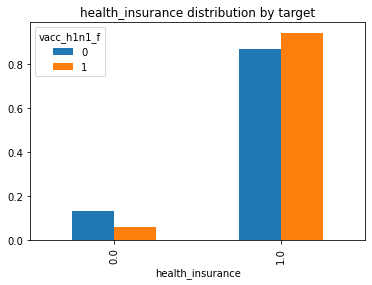

In [39]:
EDA_plot1(df,'health_insurance')

- Note : boolean

In [40]:
type_feature['health_insurance'] = 'bool'

##### health_worker

- Description : Is a healthcare worker.

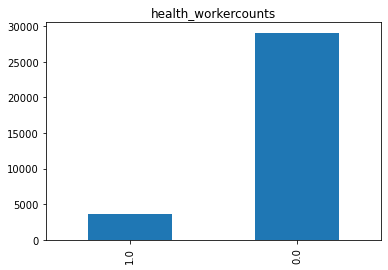

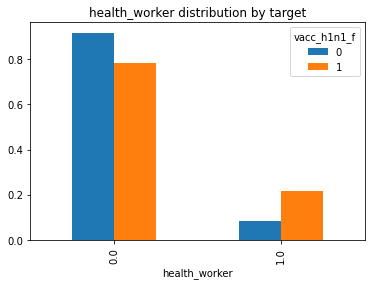

In [41]:
EDA_plot1(df,'health_worker')

- Note : boolean

In [42]:
type_feature['health_worker'] = 'bool'

##### opinion_h1n1_vacc_effective

- Description : Respondent's opinion about H1N1 vaccine effectiveness.   

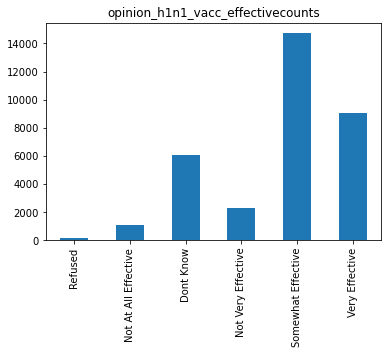

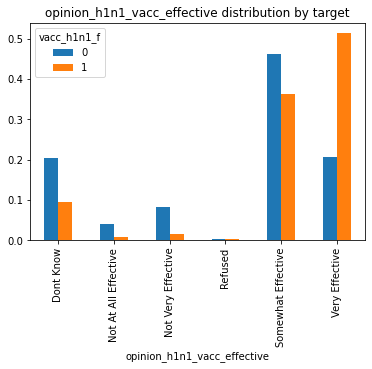

In [43]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

- Note : ordinal variable

In [44]:
type_feature['opinion_h1n1_vacc_effective'] = 'ordinal'
df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',1,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',2,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Dont Know',3,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',4,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Very Effective',5,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)


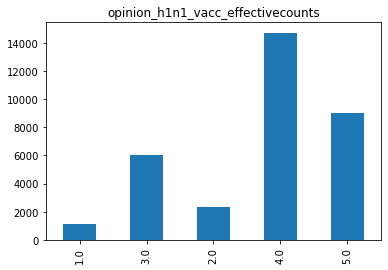

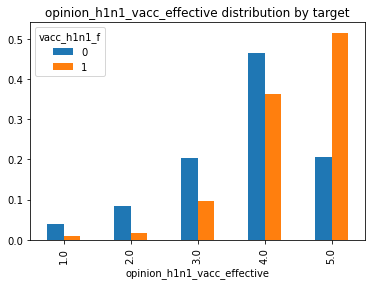

In [45]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

##### opinion_h1n1_risk

- Description : Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.  

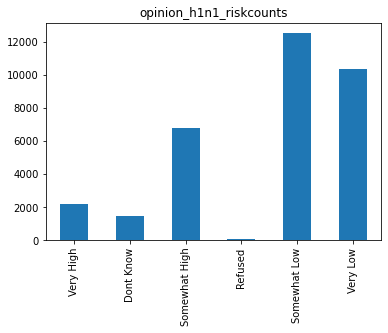

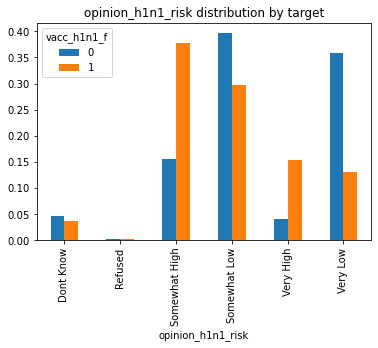

In [46]:
EDA_plot1(df,'opinion_h1n1_risk')

- Note : ordinal type

In [47]:
type_feature['opinion_h1n1_risk'] = 'ordinal'
df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_h1n1_risk'].replace('Dont Know',3,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat High',4,inplace=True)
df['opinion_h1n1_risk'].replace('Very High',5,inplace=True)
df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)

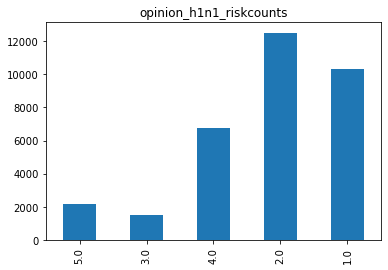

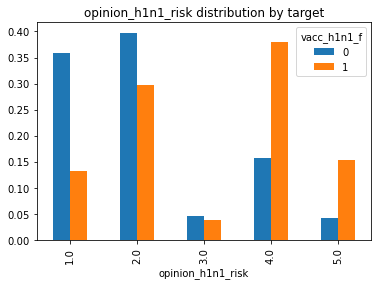

In [48]:
EDA_plot1(df,'opinion_h1n1_risk')

##### opinion_h1n1_sick_from_vacc

- Description : Respondent's worry of getting sick from taking H1N1 vaccine.   

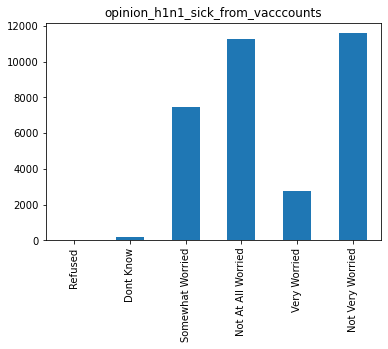

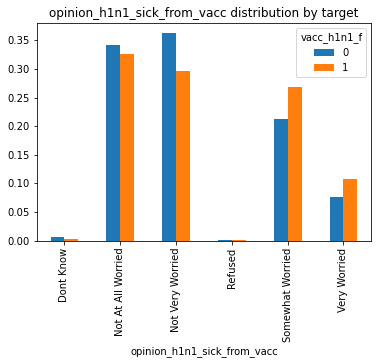

In [49]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

- Note : ordinal variable

In [50]:
type_feature['opinion_h1n1_sick_from_vacc'] = 'ordinal'
df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',1,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',2,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',3,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',4,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',5,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)


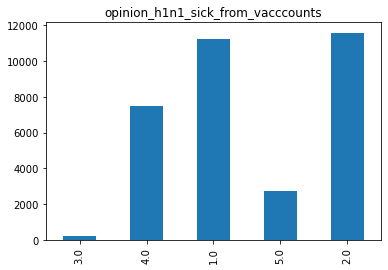

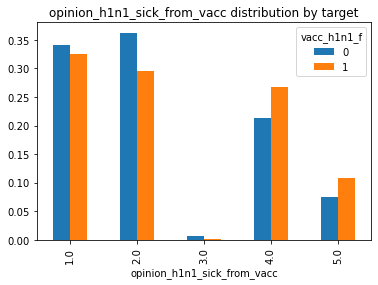

In [51]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

##### opinion_seas_vacc_effective

- Description : Respondent's opinion about seasonal flu vaccine effectiveness.   

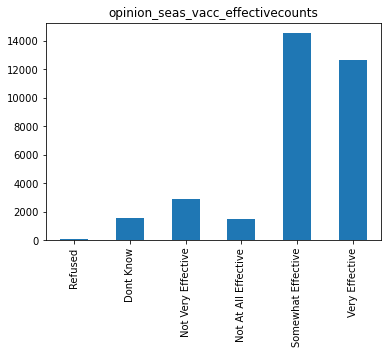

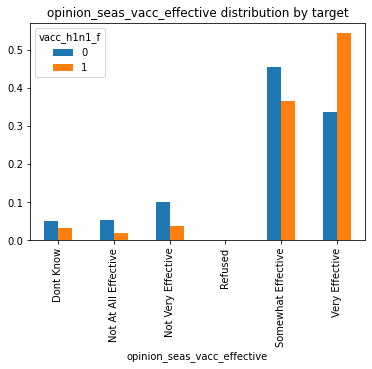

In [52]:
EDA_plot1(df,'opinion_seas_vacc_effective')

- Note : ordinal variable

In [53]:
type_feature['opinion_seas_vacc_effective'] = 'ordinal'
df['opinion_seas_vacc_effective'].replace('Not At All Effective',1,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not Very Effective',2,inplace=True)
df['opinion_seas_vacc_effective'].replace('Dont Know',3,inplace=True)
df['opinion_seas_vacc_effective'].replace('Somewhat Effective',4,inplace=True)
df['opinion_seas_vacc_effective'].replace('Very Effective',5,inplace=True)
df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)

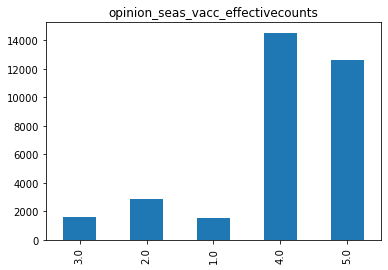

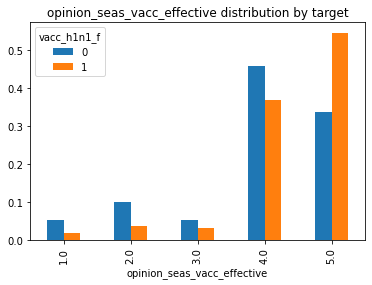

In [54]:
EDA_plot1(df,'opinion_seas_vacc_effective')

##### opinion_seas_risk

- Description : Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   

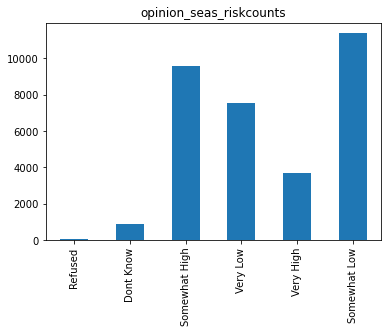

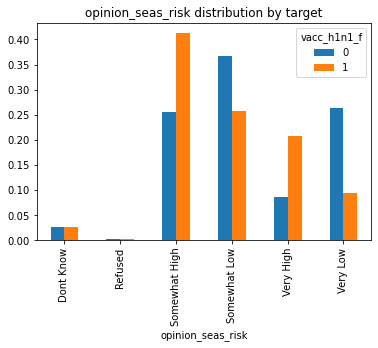

In [55]:
EDA_plot1(df,'opinion_seas_risk')

- Note : ordinal variable

In [56]:
type_feature['opinion_seas_risk'] = 'ordinal' # change later
df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_seas_risk'].replace('Dont Know',3,inplace=True)
df['opinion_seas_risk'].replace('Somewhat High',4,inplace=True)
df['opinion_seas_risk'].replace('Very High',5,inplace=True)
df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)

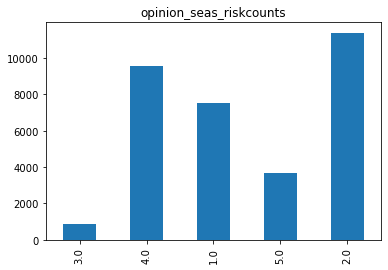

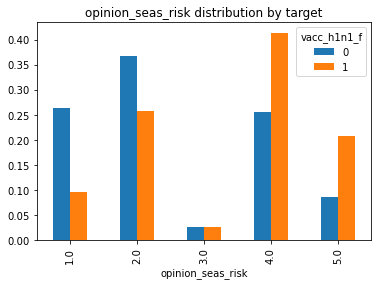

In [57]:
EDA_plot1(df,'opinion_seas_risk')

##### opinion_seas_sick_from_vacc

- Description : Respondent's worry of getting sick from taking seasonal flu vaccine.  

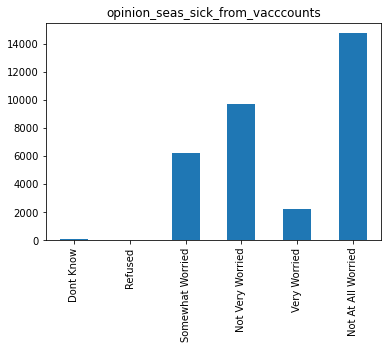

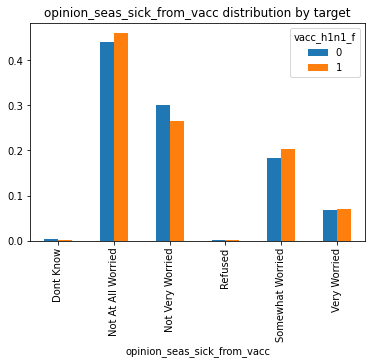

In [58]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

- Note : ordinal variable

In [59]:
type_feature['opinion_seas_sick_from_vacc'] = 'ordinal'
df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',1,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',2,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Dont Know',3,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',4,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Very Worried',5,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)


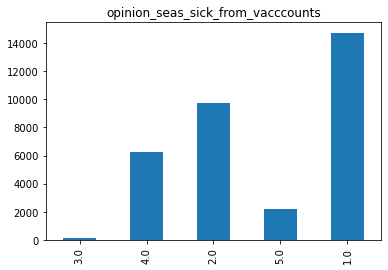

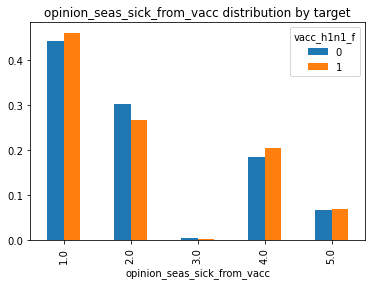

In [60]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

##### agegrp

- Description : Age group of respondent.   

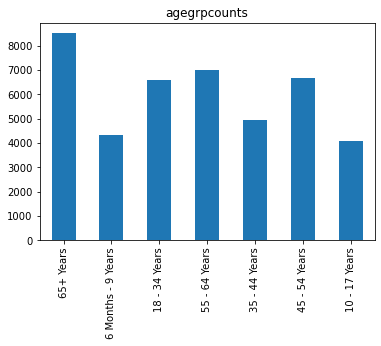

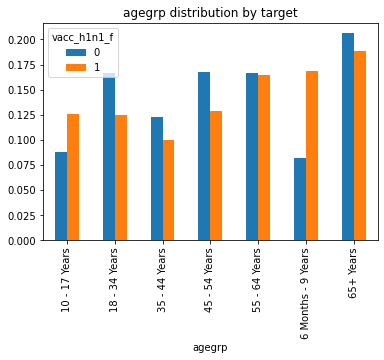

In [61]:
EDA_plot1(df,'agegrp')

- Note : ordinal type

In [62]:
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)
type_feature['agegrp'] = 'ordinal'

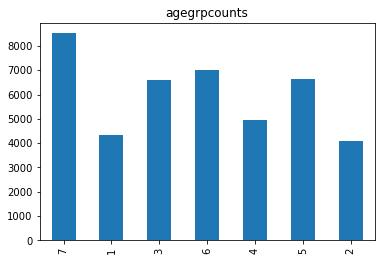

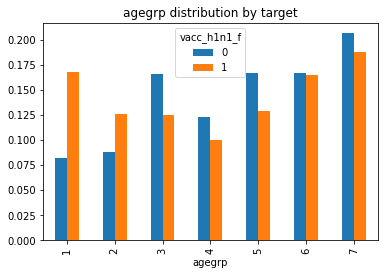

In [63]:
EDA_plot1(df,'agegrp')

- whether one is student or not is significant

##### education_comp

- Description : Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   

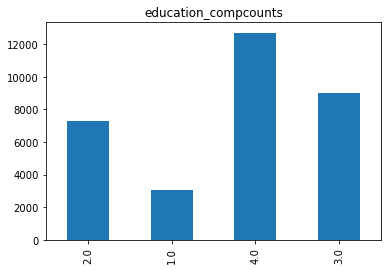

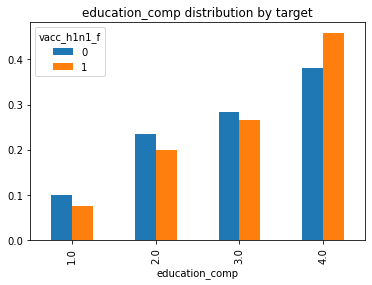

In [64]:
EDA_plot1(df,'education_comp')

- Note : ordinal

In [65]:
type_feature['education_comp'] = 'ordinal'

##### raceeth4_i

- Description : Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   

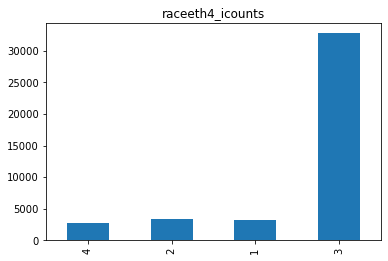

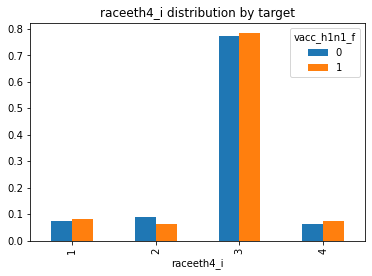

In [66]:
EDA_plot1(df,'raceeth4_i')

- Note : categorical type

In [67]:
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
type_feature['raceeth4_i'] = 'nominal'

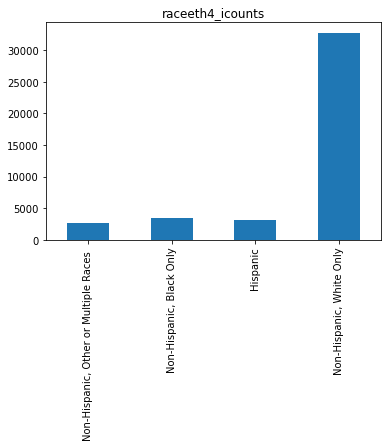

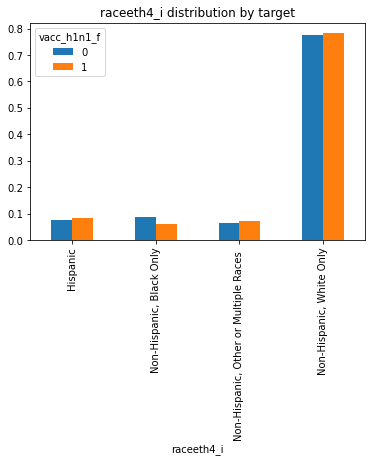

In [68]:
EDA_plot1(df,'raceeth4_i')

- Note : black or not

##### sex_i

- Description : Sex of respondent.   
1 = Male; 2 = Female   

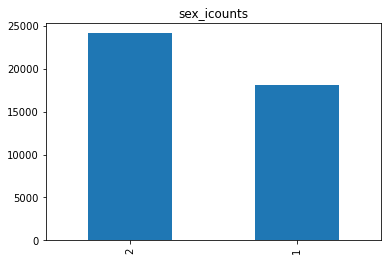

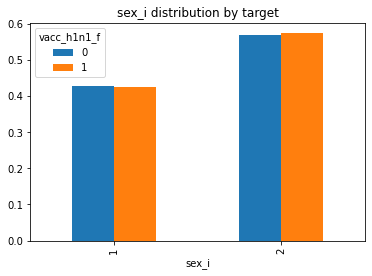

In [69]:
EDA_plot1(df,'sex_i')

- Note : boolean, Male=True, Female=False

In [70]:
df['sex_i'].replace(2,0,inplace=True)
type_feature['sex_i'] = 'bool'

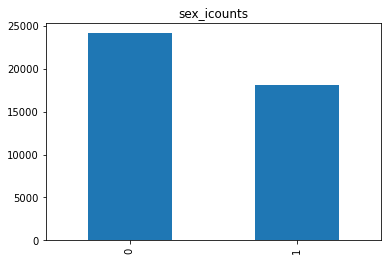

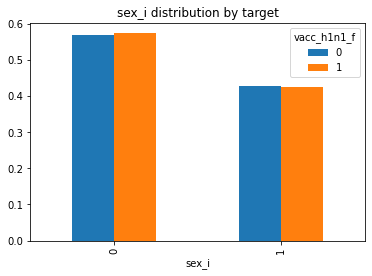

In [71]:
EDA_plot1(df,'sex_i')

- Note : insignificant

##### inc_pov

- Description : Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 : > $75,000; 2 : <= $75,000; 3 : Below Poverty; 4 : Unknown   

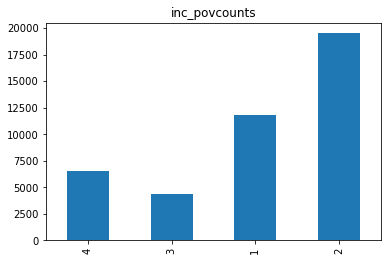

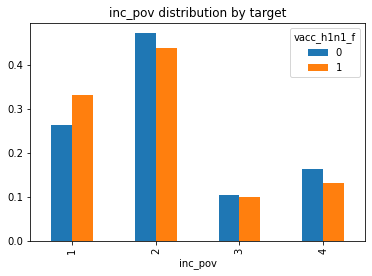

In [72]:
EDA_plot1(df,'inc_pov')

- Note : ordered categorical type, 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [73]:
type_feature['inc_pov'] = 'ordinal'
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)

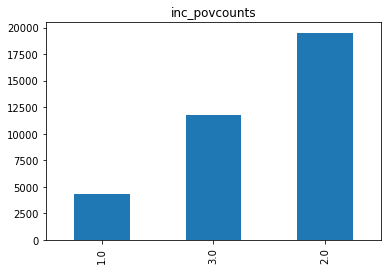

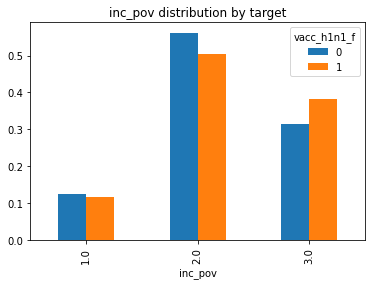

In [74]:
EDA_plot1(df,'inc_pov')

##### marital

- Description : Marital status of respondent.   
1 = Married; 2 = Not Married   

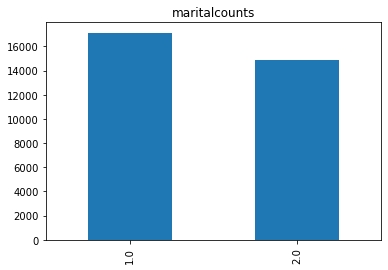

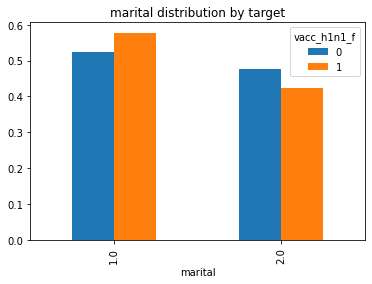

In [75]:
EDA_plot1(df,'marital')

- Note : boolean

In [76]:
df['marital'].replace(2,0,inplace=True)
type_feature['marital'] = 'bool'

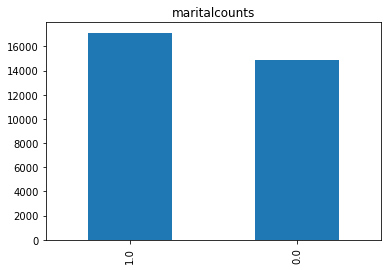

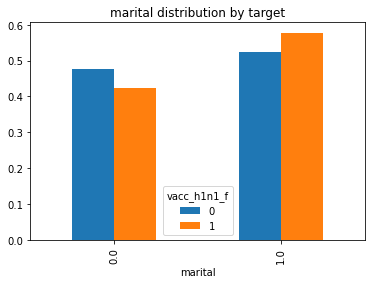

In [77]:
EDA_plot1(df,'marital')

##### rent_own_r

- Description : Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   

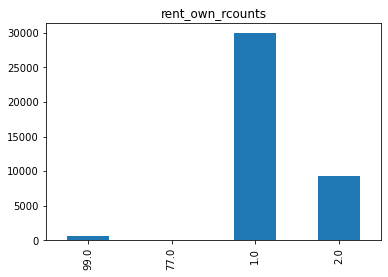

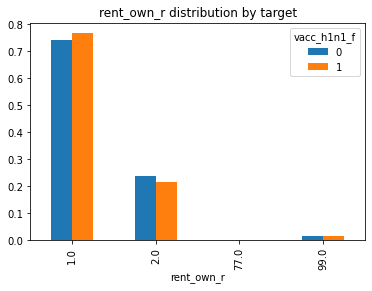

In [78]:
EDA_plot1(df,'rent_own_r')

- Note : boolean, Outliers(77,99 -> np.nan)

In [79]:
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(2,0,inplace=True)
type_feature['rent_own_r'] = 'bool'

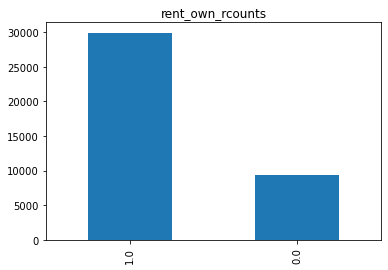

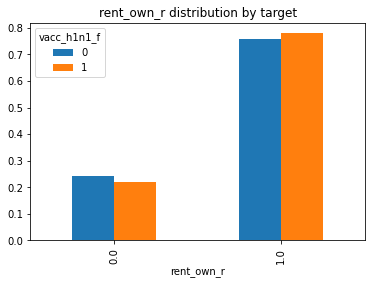

In [80]:
EDA_plot1(df,'rent_own_r')

##### employment_status

- Description : Employment status of respondent.   

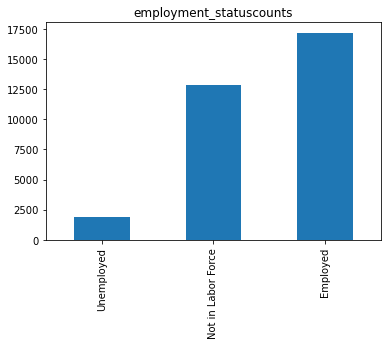

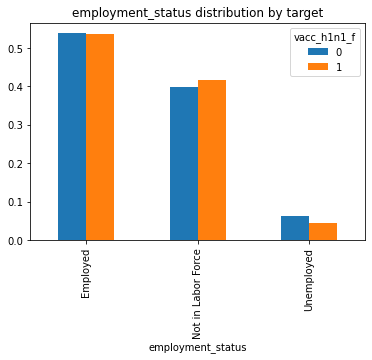

In [81]:
EDA_plot1(df,'employment_status')

- Note : disorder

In [82]:
type_feature['employment_status'] = 'nominal'

##### census_region

- Description : True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   

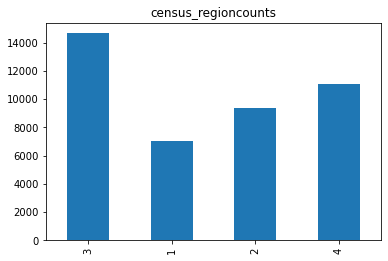

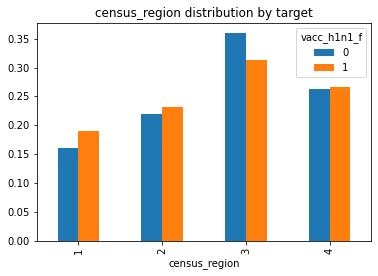

In [83]:
EDA_plot1(df,'census_region')

- Note : categorical type, location information

In [84]:
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
type_feature['census_region'] = 'nominal'

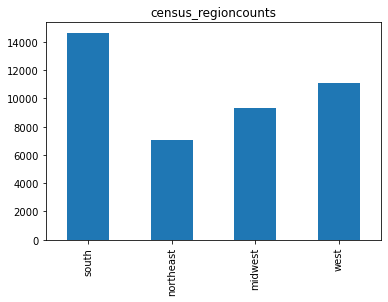

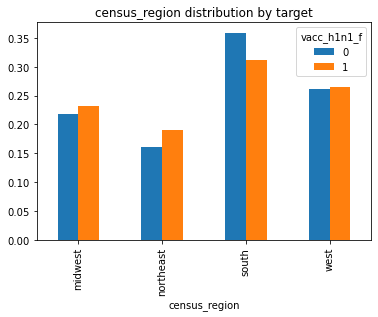

In [85]:
EDA_plot1(df,'census_region')

##### census_msa

- Description : Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   

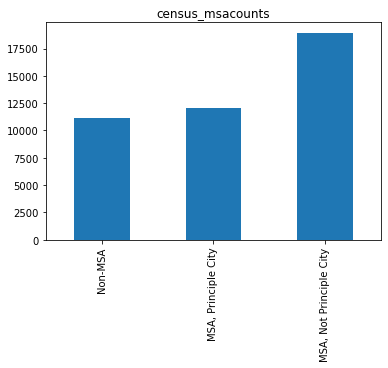

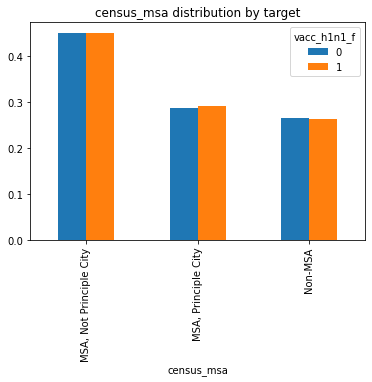

In [86]:
EDA_plot1(df,'census_msa')

- Note : ordered categorical type, location information

In [87]:
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)
type_feature['census_msa'] = 'ordinal'

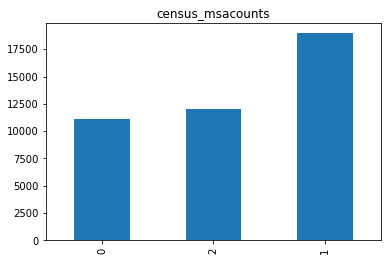

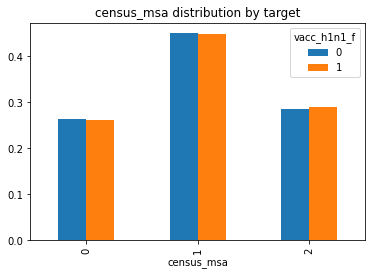

In [88]:
EDA_plot1(df,'census_msa')

##### n_adult_r

- Description : Number of other adults in household.   

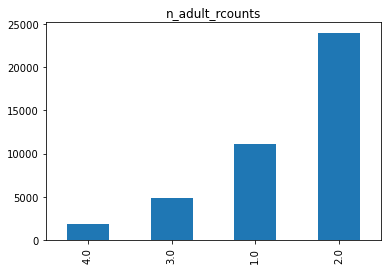

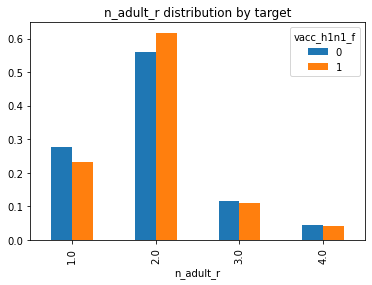

In [89]:
EDA_plot1(df,'n_adult_r')

- Note : ratio type

In [90]:
type_feature['n_adult_r'] = 'ratio'

##### household_children

- Description : Number of children in household.   

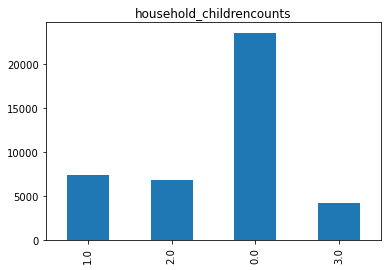

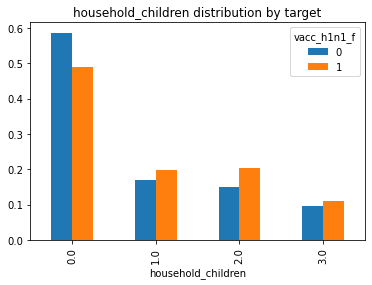

In [91]:
EDA_plot1(df,'household_children')

- Note : ratio type

In [92]:
type_feature['household_children'] = 'ratio'

##### n_people_r

- Description : Number of adults in the household.   

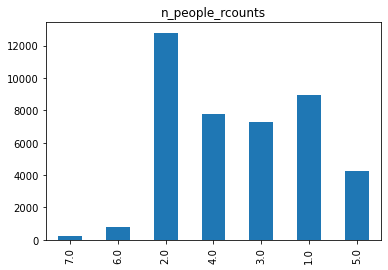

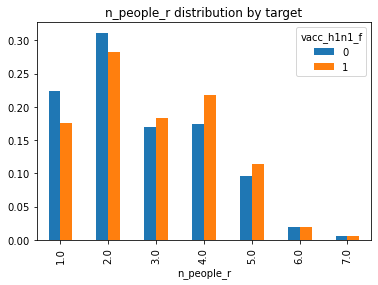

In [93]:
EDA_plot1(df,'n_people_r')

- Note : ratio type

In [94]:
type_feature['n_people_r'] = 'ratio'

##### employment_industry

- Description : Type of industry respondent is employed in.   

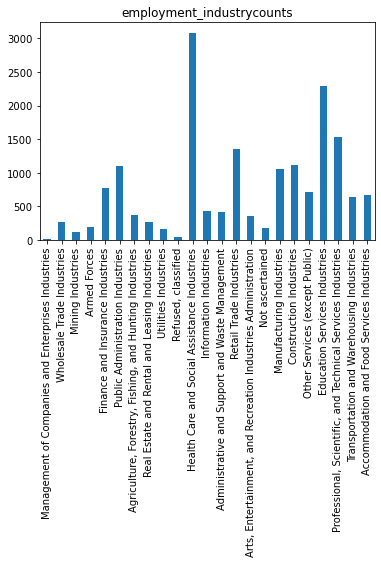

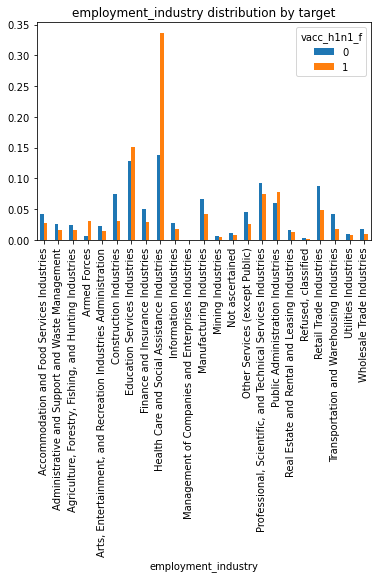

In [95]:
EDA_plot1(df,'employment_industry')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_occupation

In [96]:
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_industry'] = 'nominal'

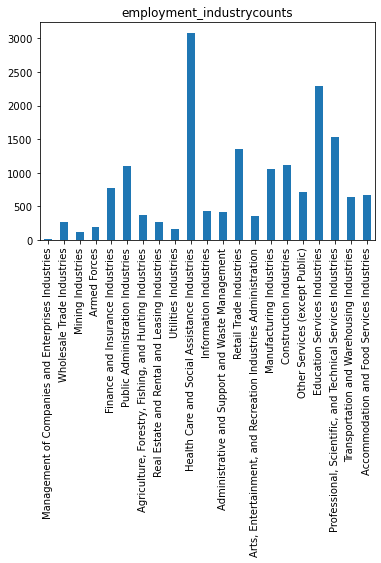

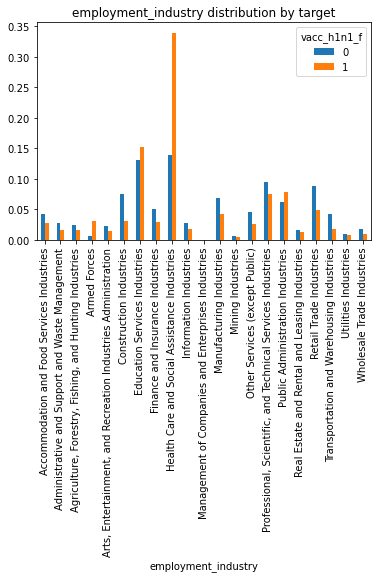

In [97]:
EDA_plot1(df,'employment_industry')

##### employment_occupation

- Description : Type of occupation of respondent. Values are represented as short random character strings.   

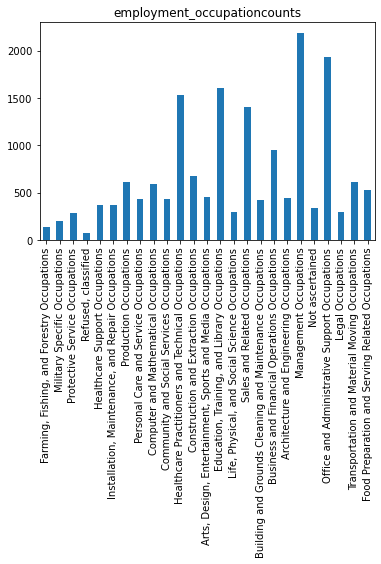

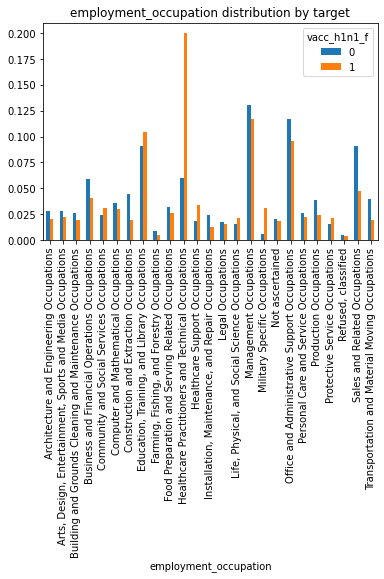

In [98]:
EDA_plot1(df,'employment_occupation')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_industry

In [99]:
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_occupation'] = 'nominal'

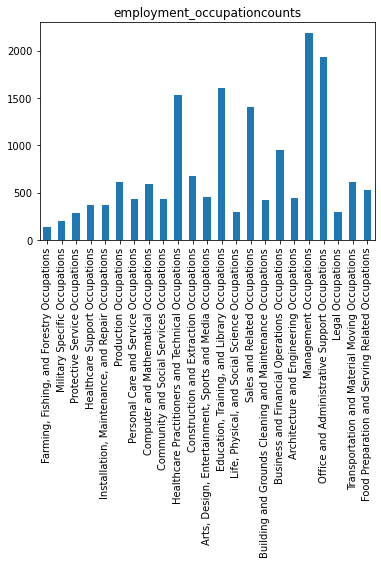

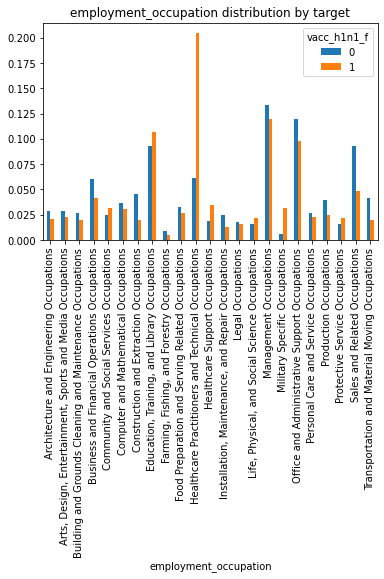

In [100]:
EDA_plot1(df,'employment_occupation')

##### hhs_region

- Description : HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   

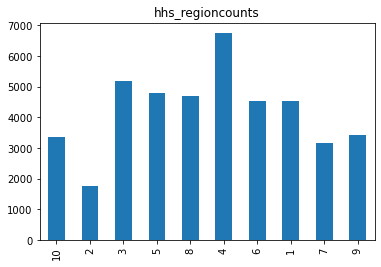

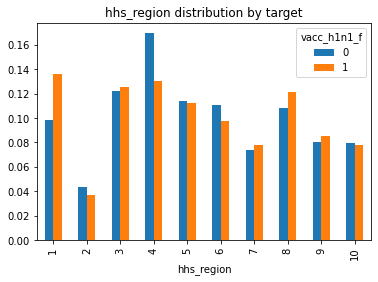

In [101]:
EDA_plot1(df,'hhs_region')

- Note : categorical type, location information, high cardinality

In [102]:
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
type_feature['hhs_region'] = 'nominal'

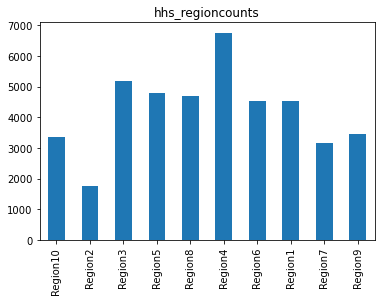

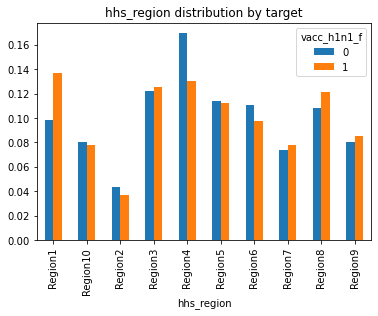

In [103]:
EDA_plot1(df,'hhs_region')

##### state

- Description : State of residence   

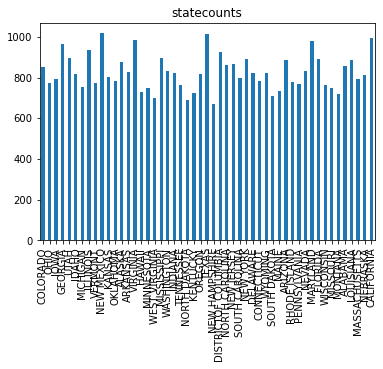

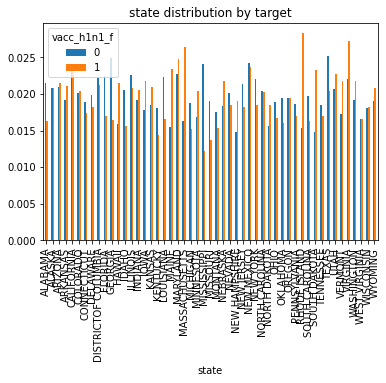

In [104]:
EDA_plot1(df,'state')

- Note : categorical type, local information, high cardinality

In [105]:
df['state'].replace('ALABAMA','AL',inplace=True)
df['state'].replace('ALASKA','AK',inplace=True)
df['state'].replace('ARIZONA','AZ',inplace=True)
df['state'].replace('ARKANSAS','AR',inplace=True)
df['state'].replace('CALIFORNIA','CA',inplace=True)
df['state'].replace('COLORADO','CO',inplace=True)
df['state'].replace('CONNECTICUT','CT',inplace=True)
df['state'].replace('DELAWARE','DE',inplace=True)
df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
df['state'].replace('FLORIDA','FL',inplace=True)
df['state'].replace('GEORGIA','GA',inplace=True)
df['state'].replace('HAWAII','HI',inplace=True)
df['state'].replace('IDAHO','ID',inplace=True)
df['state'].replace('ILLINOIS','IL',inplace=True)
df['state'].replace('INDIANA','IN',inplace=True)
df['state'].replace('IOWA','IA',inplace=True)
df['state'].replace('KANSAS','KS',inplace=True)
df['state'].replace('KENTUCKY','KY',inplace=True)
df['state'].replace('LOUISIANA','LA',inplace=True)
df['state'].replace('MAINE','ME',inplace=True)
df['state'].replace('MARYLAND','MD',inplace=True)
df['state'].replace('MASSACHUSETTS','MA',inplace=True)
df['state'].replace('MICHIGAN','MI',inplace=True)
df['state'].replace('MINNESOTA','MN',inplace=True)
df['state'].replace('MISSISSIPPI','MS',inplace=True)
df['state'].replace('MISSOURI','MO',inplace=True)
df['state'].replace('MONTANA','MT',inplace=True)
df['state'].replace('NEBRASKA','NE',inplace=True)
df['state'].replace('NEVADA','NV',inplace=True)
df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
df['state'].replace('NEW JERSEY','NJ',inplace=True)
df['state'].replace('NEW MEXICO','NM',inplace=True)
df['state'].replace('NEW YORK','NY',inplace=True)
df['state'].replace('NORTH CAROLINA','NC',inplace=True)
df['state'].replace('NORTH DAKOTA','ND',inplace=True)
df['state'].replace('OHIO','OH',inplace=True)
df['state'].replace('OKLAHOMA','OK',inplace=True)
df['state'].replace('OREGON','OR',inplace=True)
df['state'].replace('PENNSYLVANIA','PA',inplace=True)
df['state'].replace('RHODE ISLAND','RI',inplace=True)
df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
df['state'].replace('TENNESSEE','TN',inplace=True)
df['state'].replace('TEXAS','TX',inplace=True)
df['state'].replace('UTAH','UT',inplace=True)
df['state'].replace('VERMONT','VT',inplace=True)
df['state'].replace('VIRGINIA','VA',inplace=True)
df['state'].replace('WASHINGTON','WA',inplace=True)
df['state'].replace('WEST VIRGINIA','WV',inplace=True)
df['state'].replace('WISCONSIN','WI',inplace=True)
df['state'].replace('WYOMING','WY',inplace=True)
type_feature['state'] = 'nominal'

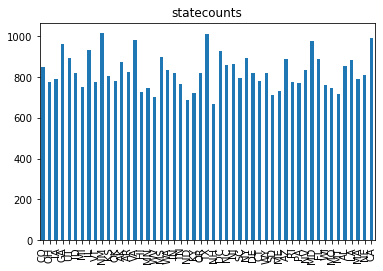

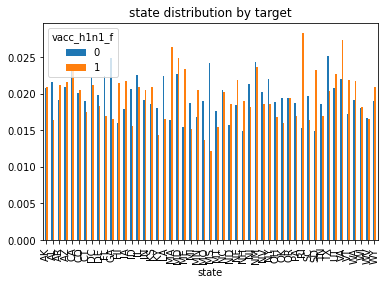

In [106]:
EDA_plot1(df,'state')

##### map visualization
feature : state, hhs_region, census_region

In [107]:
import json
import requests
from matplotlib.patches import Polygon
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
dc={"type":"Feature","id":"DC","properties":{"name":"District of Columbia"},"geometry":{"type":"Polygon","coordinates":[[[-77.040741, 38.791222],[-76.909294, 38.895284],[-77.035264, 38.993869],[-77.117418, 38.933623]]]}}
state_geo=dict(json.loads(requests.get(state_geo).text))['features']
state_geo.append(dc)

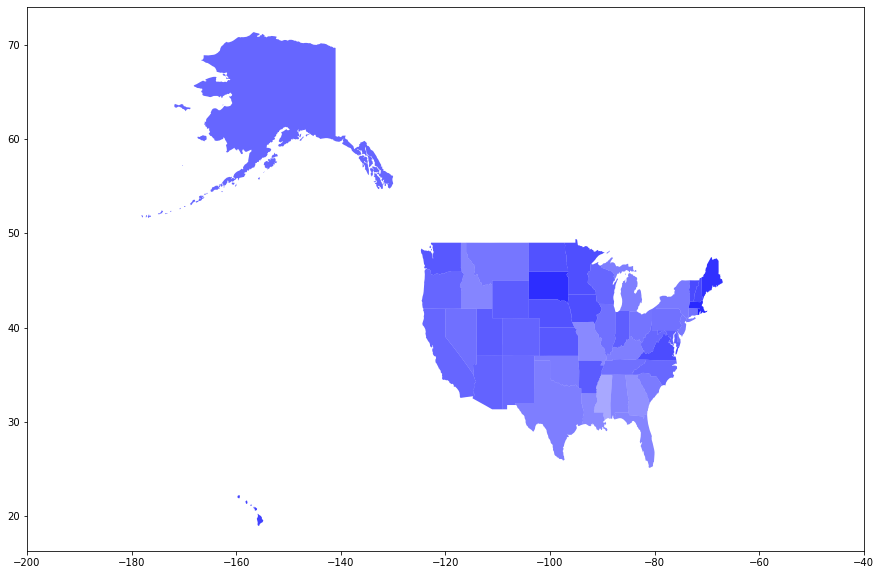

In [108]:
# vaccine rate group by state
vacc_rate_geo=df[['state','vacc_h1n1_f']].groupby(['state']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

In [109]:
# region relationships, census_msa can't be seperated by state
hhs={}
for i in range(10):
    hhs[f'Region{i+1}']=[]
census={
    'west':[],
    'midwest':[],
    'northeast':[],
    'south':[]
}
for s in df['state'].unique():
    hhs[df[df['state']==s]['hhs_region'].unique()[0]].append(s)
    census[df[df['state']==s]['census_region'].unique()[0]].append(s)
region_dict={}
for s in df['state'].unique():
    region_dict[s]=[df[df['state']==s]['hhs_region'].unique()[0],df[df['state']==s]['census_region'].unique()[0]]

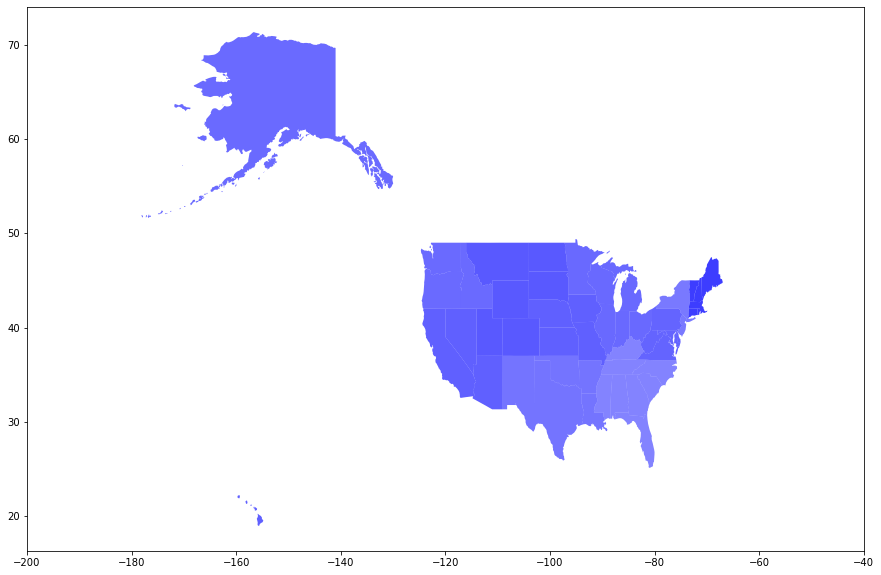

In [110]:
# vaccine rate group by hhs_region
vacc_rate_hhs=df[['hhs_region','vacc_h1n1_f']].groupby(['hhs_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

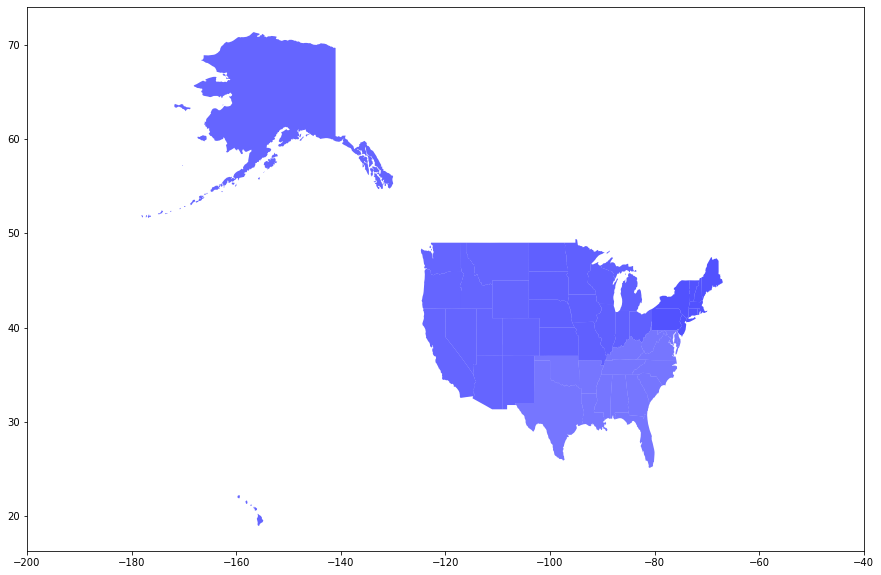

In [111]:
# vaccine rate group by census_region
vacc_rate_census=df[['census_region','vacc_h1n1_f']].groupby(['census_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

(state, hhs_region, census_region)x(vacc_h1n1_f, ...) more EDA probability

In [112]:
def EDA1(data):
    df_temp = copy.deepcopy(data)
    df_temp['opinion_h1n1_vacc_effective'].replace('Not At All Effective',1,inplace=True)
    df_temp['opinion_h1n1_vacc_effective'].replace('Not Very Effective',2,inplace=True)
    df_temp['opinion_h1n1_vacc_effective'].replace('Dont Know',3,inplace=True)
    df_temp['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',4,inplace=True)
    df_temp['opinion_h1n1_vacc_effective'].replace('Very Effective',5,inplace=True)
    df_temp['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
    df_temp['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
    df_temp['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
    df_temp['opinion_h1n1_risk'].replace('Dont Know',3,inplace=True)
    df_temp['opinion_h1n1_risk'].replace('Somewhat High',4,inplace=True)
    df_temp['opinion_h1n1_risk'].replace('Very High',5,inplace=True)
    df_temp['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
    df_temp['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',1,inplace=True)
    df_temp['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',2,inplace=True)
    df_temp['opinion_h1n1_sick_from_vacc'].replace('Dont Know',3,inplace=True)
    df_temp['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',4,inplace=True)
    df_temp['opinion_h1n1_sick_from_vacc'].replace('Very Worried',5,inplace=True)
    df_temp['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
    df_temp['opinion_seas_vacc_effective'].replace('Not At All Effective',1,inplace=True)
    df_temp['opinion_seas_vacc_effective'].replace('Not Very Effective',2,inplace=True)
    df_temp['opinion_seas_vacc_effective'].replace('Dont Know',3,inplace=True)
    df_temp['opinion_seas_vacc_effective'].replace('Somewhat Effective',4,inplace=True)
    df_temp['opinion_seas_vacc_effective'].replace('Very Effective',5,inplace=True)
    df_temp['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
    df_temp['opinion_seas_risk'].replace('Very Low',1,inplace=True)
    df_temp['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
    df_temp['opinion_seas_risk'].replace('Dont Know',3,inplace=True)
    df_temp['opinion_seas_risk'].replace('Somewhat High',4,inplace=True)
    df_temp['opinion_seas_risk'].replace('Very High',5,inplace=True)
    df_temp['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
    df_temp['opinion_seas_sick_from_vacc'].replace('Not At All Worried',1,inplace=True)
    df_temp['opinion_seas_sick_from_vacc'].replace('Not Very Worried',2,inplace=True)
    df_temp['opinion_seas_sick_from_vacc'].replace('Dont Know',3,inplace=True)
    df_temp['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',4,inplace=True)
    df_temp['opinion_seas_sick_from_vacc'].replace('Very Worried',5,inplace=True)
    df_temp['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
    df_temp['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
    df_temp['agegrp'].replace('10 - 17 Years',2,inplace=True)
    df_temp['agegrp'].replace('18 - 34 Years',3,inplace=True)
    df_temp['agegrp'].replace('35 - 44 Years',4,inplace=True)
    df_temp['agegrp'].replace('45 - 54 Years',5,inplace=True)
    df_temp['agegrp'].replace('55 - 64 Years',6,inplace=True)
    df_temp['agegrp'].replace('65+ Years',7,inplace=True)
    df_temp['raceeth4_i'].replace(1,'Hispanic',inplace=True)
    df_temp['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
    df_temp['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
    df_temp['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
    df_temp['sex_i'].replace(2,0,inplace=True)
    df_temp['inc_pov'].replace(4,np.nan,inplace=True)
    df_temp['inc_pov'].replace(3,5,inplace=True)
    df_temp['inc_pov'].replace(1,3,inplace=True)
    df_temp['inc_pov'].replace(5,1,inplace=True)
    df_temp['marital'].replace(2,0,inplace=True)
    df_temp['rent_own_r'].replace(77,np.nan,inplace=True)
    df_temp['rent_own_r'].replace(99,np.nan,inplace=True)
    df_temp['rent_own_r'].replace(2,0,inplace=True)
    df_temp['census_region'].replace(1,'northeast',inplace=True)
    df_temp['census_region'].replace(2,'midwest',inplace=True)
    df_temp['census_region'].replace(3,'south',inplace=True)
    df_temp['census_region'].replace(4,'west',inplace=True)
    df_temp['census_msa'].replace('Non-MSA',0,inplace=True)
    df_temp['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
    df_temp['census_msa'].replace('MSA, Principle City',2,inplace=True)
    df_temp['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
    df_temp['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
    df_temp['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
    df_temp['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
    df_temp['hhs_region']=df_temp['hhs_region'].map(lambda x: 'Region'+str(x))
    df_temp['state'].replace('ALABAMA','AL',inplace=True)
    df_temp['state'].replace('ALASKA','AK',inplace=True)
    df_temp['state'].replace('ARIZONA','AZ',inplace=True)
    df_temp['state'].replace('ARKANSAS','AR',inplace=True)
    df_temp['state'].replace('CALIFORNIA','CA',inplace=True)
    df_temp['state'].replace('COLORADO','CO',inplace=True)
    df_temp['state'].replace('CONNECTICUT','CT',inplace=True)
    df_temp['state'].replace('DELAWARE','DE',inplace=True)
    df_temp['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
    df_temp['state'].replace('FLORIDA','FL',inplace=True)
    df_temp['state'].replace('GEORGIA','GA',inplace=True)
    df_temp['state'].replace('HAWAII','HI',inplace=True)
    df_temp['state'].replace('IDAHO','ID',inplace=True)
    df_temp['state'].replace('ILLINOIS','IL',inplace=True)
    df_temp['state'].replace('INDIANA','IN',inplace=True)
    df_temp['state'].replace('IOWA','IA',inplace=True)
    df_temp['state'].replace('KANSAS','KS',inplace=True)
    df_temp['state'].replace('KENTUCKY','KY',inplace=True)
    df_temp['state'].replace('LOUISIANA','LA',inplace=True)
    df_temp['state'].replace('MAINE','ME',inplace=True)
    df_temp['state'].replace('MARYLAND','MD',inplace=True)
    df_temp['state'].replace('MASSACHUSETTS','MA',inplace=True)
    df_temp['state'].replace('MICHIGAN','MI',inplace=True)
    df_temp['state'].replace('MINNESOTA','MN',inplace=True)
    df_temp['state'].replace('MISSISSIPPI','MS',inplace=True)
    df_temp['state'].replace('MISSOURI','MO',inplace=True)
    df_temp['state'].replace('MONTANA','MT',inplace=True)
    df_temp['state'].replace('NEBRASKA','NE',inplace=True)
    df_temp['state'].replace('NEVADA','NV',inplace=True)
    df_temp['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
    df_temp['state'].replace('NEW JERSEY','NJ',inplace=True)
    df_temp['state'].replace('NEW MEXICO','NM',inplace=True)
    df_temp['state'].replace('NEW YORK','NY',inplace=True)
    df_temp['state'].replace('NORTH CAROLINA','NC',inplace=True)
    df_temp['state'].replace('NORTH DAKOTA','ND',inplace=True)
    df_temp['state'].replace('OHIO','OH',inplace=True)
    df_temp['state'].replace('OKLAHOMA','OK',inplace=True)
    df_temp['state'].replace('OREGON','OR',inplace=True)
    df_temp['state'].replace('PENNSYLVANIA','PA',inplace=True)
    df_temp['state'].replace('RHODE ISLAND','RI',inplace=True)
    df_temp['state'].replace('SOUTH CAROLINA','SC',inplace=True)
    df_temp['state'].replace('SOUTH DAKOTA','SD',inplace=True)
    df_temp['state'].replace('TENNESSEE','TN',inplace=True)
    df_temp['state'].replace('TEXAS','TX',inplace=True)
    df_temp['state'].replace('UTAH','UT',inplace=True)
    df_temp['state'].replace('VERMONT','VT',inplace=True)
    df_temp['state'].replace('VIRGINIA','VA',inplace=True)
    df_temp['state'].replace('WASHINGTON','WA',inplace=True)
    df_temp['state'].replace('WEST VIRGINIA','WV',inplace=True)
    df_temp['state'].replace('WISCONSIN','WI',inplace=True)
    df_temp['state'].replace('WYOMING','WY',inplace=True)
    return df_temp

In [113]:
train = EDA1(train)

#### Multivariate analysis

##### Missing pattern and Structurally missing data

In [114]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns = map(lambda x: x+'_mv',df.columns)
df_MV=df_MV[df_MV.columns[df_MV.sum().map(bool).tolist()]]
df_MV.head()

h1n1_concern_mv  h1n1_knowledge_mv  behavioral_antiviral_meds_mv  \
0             True               True                          True   
1            False              False                         False   
2            False              False                         False   
3            False              False                         False   
4            False              False                         False   

   behavioral_avoidance_mv  behavioral_face_mask_mv  behavioral_wash_hands_mv  \
0                     True                     True                      True   
1                    False                    False                     False   
2                    False                    False                     False   
3                    False                    False                     False   
4                    False                    False                     False   

   behavioral_large_gatherings_mv  behavioral_outside_home_mv  \
0                            True                        True   
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   behavioral_touch_face_mv  doctor_recc_h1n1_mv  ...  education_comp_mv  \
0                      True                False  ...               True   
1                     False                False  ...              False   
2                     False                False  ...              False   
3                     False                False  ...              False   
4                     False                False  ...              False   

   inc_pov_mv  marital_mv  rent_own_r_mv  employment_status_mv  n_adult_r_mv  \
0       False        True          False                  True         False   
1       False       False          False                 False         False   
2       False       False          False                 False         False   
3       False       False          False                 False         False   
4       False       False          False                 False         False   

   household_children_mv  n_people_r_mv  employment_industry_mv  \
0                  False          False                    True   
1                  False          False                   False   
2                  False          False                   False   
3                  False          False                   False   
4                  False          False                   False   

   employment_occupation_mv  
0                      True  
1                     False  
2                     False  
3                     False  
4                     False  

[5 rows x 31 columns]

<AxesSubplot:>

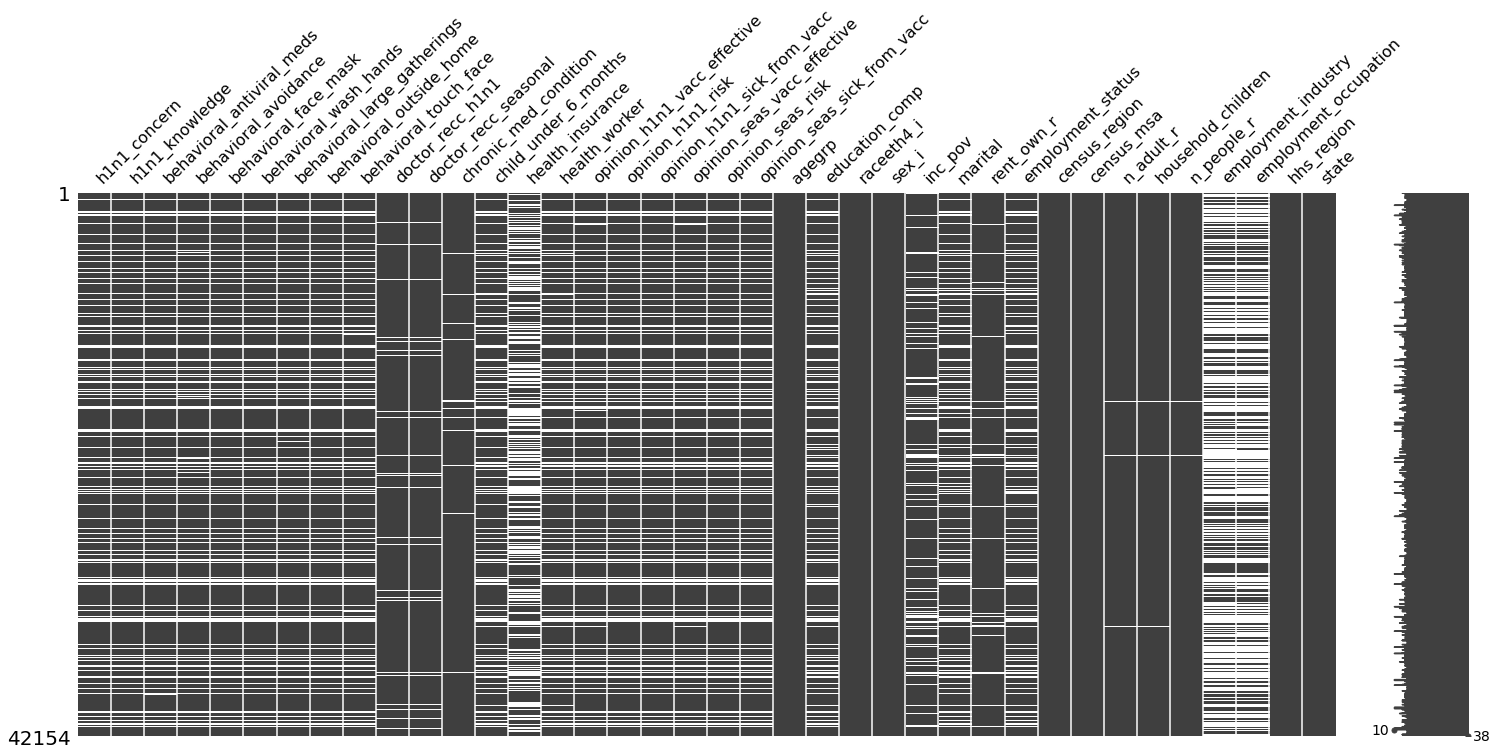

In [115]:
msno.matrix(train)

<AxesSubplot:>

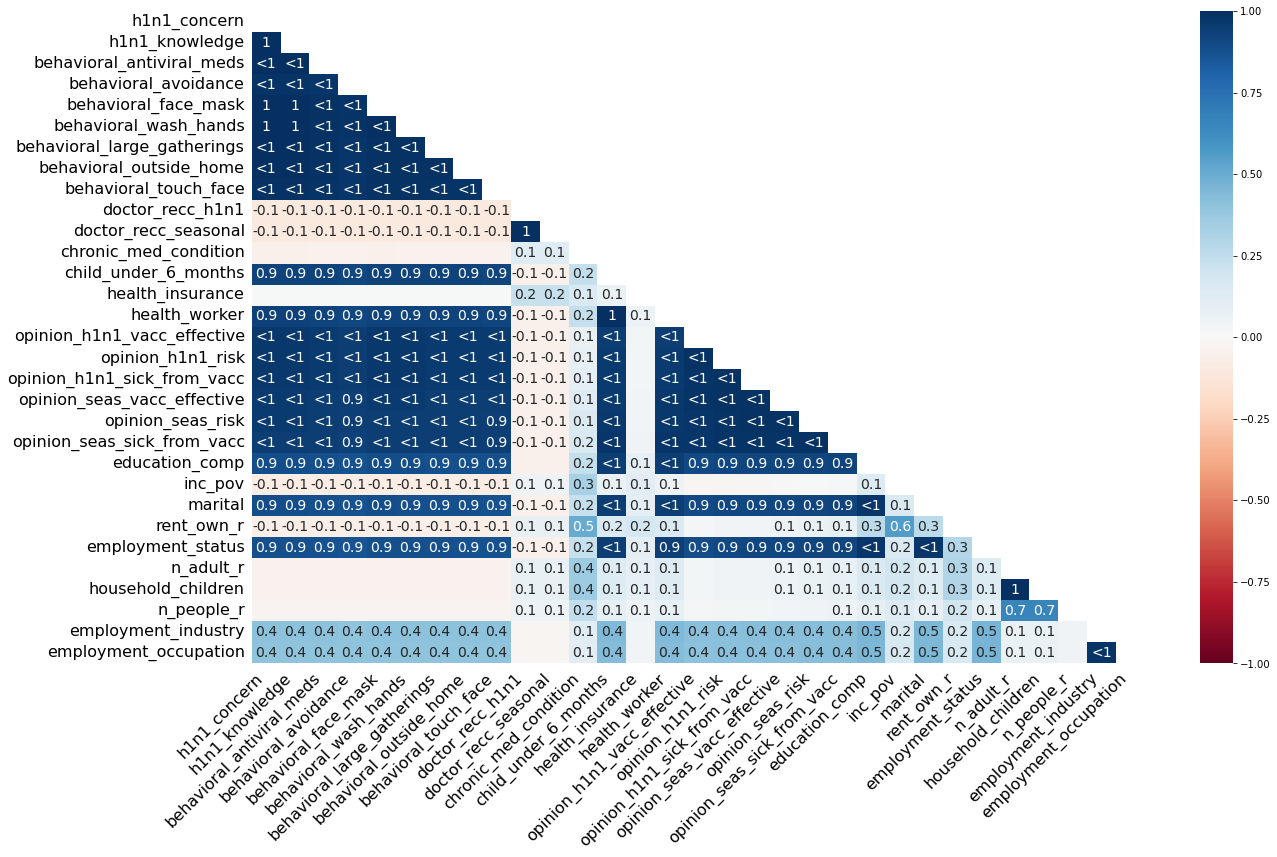

In [116]:
msno.heatmap(train)

- Missing patterns   
    - pattern_A
        - h1n1_concern
        - h1n1_knowledge
        - behavioral_antiviral_meds
        - behavioral_avoidance
        - behavioral_face_mask
        - behavioral_wash_hands
        - behavioral_large_gatherings
        - behavioral_outside_home
        - behavioral_touch_face
        - child_under_6_months
        - health_worker
        - opinion_h1n1_vacc_effective *
        - opinion_h1n1_risk
        - opinion_h1n1_sick_from_vacc
        - opinion_seas_vacc_effective
        - opinion_seas_risk
        - opinion_seas_sick_from_vacc
        - education_comp
        - marital
        - employment_status
    - pattern_B
        - doctor_recc_h1n1
        - doctor_recc_seasonal
    - pattern_C
        - n_adult_r
        - househole_children
        - n_people_r
    - pattern_D
        - employment_industry
        - employment_occupation

- response rate

In [117]:
unresponse=df_MV.sum(axis=1)

<AxesSubplot:>

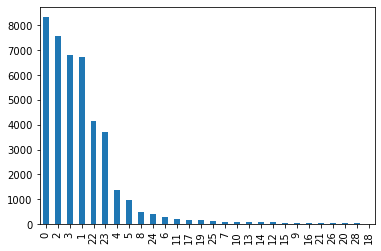

In [118]:
unresponse.value_counts().plot(kind='bar')

In [119]:
unresponse = unresponse.map(lambda x: x if x in [0,2,3,1,22,23] else 99)

- Structurally missing data

In [120]:
#corr 직접 구해야함. corr()메소드는 50개만 구함, 이거따로 바로 위로올라갈지도
df_MV_corr=pd.concat([df,df_MV],axis=1)
df.shape, df_MV.shape, df_MV_corr.shape
#이 방법 말고 structurely missing data 검출가능한가?
# smd는 특정 카테고리가 특정 feature에서 전부 nan값이 떠야함 아니면 대부분?
# 즉 특정 카테고리가 특정 feature에서 전부 nan이 뜨는 경우들 중 smd가 있음.

((42154, 40), (42154, 31), (42154, 71))

In [121]:
#agegrp에 하기전에 무직 Null값채우기 해야함. 개별분석에서 agegrp이랑 겹치는줄알고 지움
df[df['employment_status']=='Unemployed']['employment_industry'].value_counts()

Series([], Name: employment_industry, dtype: int64)

- finding structurlly missing pattern


In [122]:
n=0

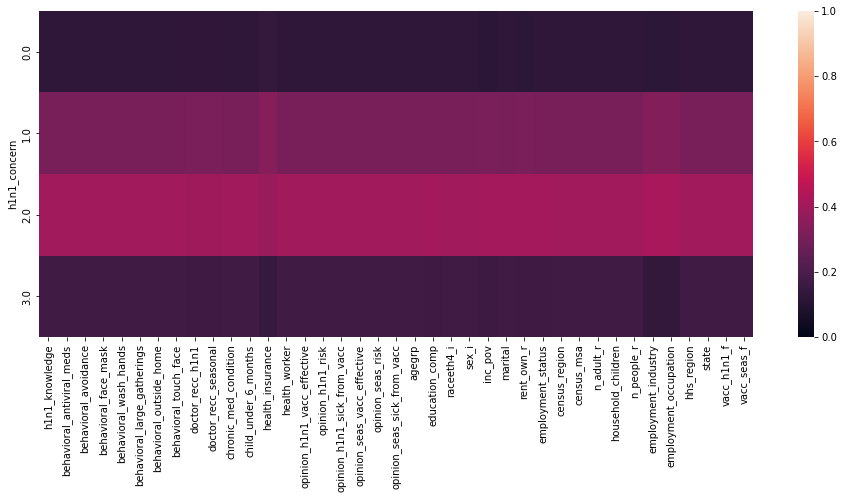

In [123]:
# execute this many times
# find missing pattern by categories of features
try:
    col = train.columns.tolist()[n]
except:
    n=0
    col = train.columns.tolist()[n]
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby(col).count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)
n+=1

In [124]:
# agegrp 1,2,7그룹으로 결측치 채우기
student = (df['agegrp'] == 1) | (df['agegrp'] == 2)
student_index = student[student==True].index
df['health_worker'].loc[student_index]=df['health_worker'].loc[student_index].map(lambda x: x if not pd.isna(x) else 1)
df['marital'].loc[student_index]=df['marital'].loc[student_index].map(lambda x: x if not pd.isna(x) else 0)
df['education_comp'].loc[student_index]=df['education_comp'].loc[student_index].map(lambda x: x if not pd.isna(x) else 1)
a=np.logical_and(df['employment_industry'].isna(),df['employment_occupation'].isna())
df['employment_status'].loc[a[a==False].index] = df['employment_status'].loc[a[a==False].index].map(lambda x: 'Employed')
df['employment_status'].loc[student_index]=df['employment_status'].loc[student_index].map(lambda x: x if not pd.isna(x) else 'student')
df['employment_industry'].loc[student_index]=df['employment_industry'].loc[student_index].map(lambda x: x if not pd.isna(x) else 'student')
df['employment_occupation'].loc[student_index]=df['employment_occupation'].loc[student_index].map(lambda x: x if not pd.isna(x) else 'student')
a=df['employment_status'] =='Unemployed'
a=a[a==True].index
df['employment_occupation'].loc[a]=df['employment_occupation'].loc[a].map(lambda x: 'Unemployed')
df['employment_industry'].loc[a]=df['employment_industry'].loc[a].map(lambda x: 'Unemployed')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [125]:
# n_people_r = n_adult_r + household_children
for i in range(len(df)):
    pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
    if np.isnan(pList).sum()==1:
        if np.isnan(pList[0]):
            df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
        elif np.isnan(pList[1]):
            df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
        else:
            df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
            

##### Test of Independence

In [126]:
train_temp = copy.deepcopy(train)
for col in train_temp.columns:
    if type_feature[col]=='nominal':
        le = LabelEncoder()
        train_temp[col] = le.fit_transform(train_temp[col])
train_temp=train_temp.astype('float')

In [127]:
# nominal-nominal : chi2 and fisher
# bool-ordinal : Mann Whitney U test groupby bool
# nominal-ordinal : Kruskal–Wallis groupby nominal
# ordinal-ordinal : Mann Whitney U test
dependency = {}
for col in train_temp.columns:
    dependency[col]=[]
for i in itertools.combinations(train_temp.columns,2):
    if not set((type_feature[i[0]],type_feature[i[1]]))-set(('nominal','bool')):
        obs=pd.crosstab(train_temp[i[0]],train_temp[i[1]])
        obsl=list(itertools.chain.from_iterable(np.array(obs)))
        l=len(obsl)
        a=len(list(itertools.filterfalse(lambda x: x<5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2)))))
        if a<l/5: # fisher
            if l==4:
                p=scipy.stats.fisher_exact(obs)
                if p<0.05:
                    print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
                    dependency[i[0]].append(i[1])
                    dependency[i[1]].append(i[0])
        else: # chi2
            p=scipy.stats.chi2_contingency(obs,correction=False)[1]
            if p<0.05:
                print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
                dependency[i[0]].append(i[1])
                dependency[i[1]].append(i[0])

    elif not set((type_feature[i[0]],type_feature[i[1]]))-set(('ordinal','ratio')): # 
        temp = train_temp[list(i)].dropna()
        p=scipy.stats.mannwhitneyu(temp[i[0]],temp[i[1]])
        if p[1]<0.05:
            print(f'{i[0]} and {i[1]} are NOT independent, p={p[1]:.3f}')
            dependency[i[0]].append(i[1])
            dependency[i[1]].append(i[0])
    elif set((type_feature[i[0]],type_feature[i[1]]))==set(('bool','ratio')) or set(i)==set(('bool','ordinal')):
        temp = train_temp[list(i)].dropna()
        if type_feature[i[0]]=='bool':
            a=temp[temp[i[0]]==1]
            b=temp[temp[i[0]]==0]
        else:
            a=temp[temp[i[1]]==1]
            b=temp[temp[i[1]]==0]
        U,p=scipy.stats.mannwhitneyu(a,b)
        if p[1]<0.05:
            print(f'{i[0]} and {i[1]} are NOT independent, p={p[1]:.3f}')
            dependency[i[0]].append(i[1])
            dependency[i[1]].append(i[0])
    else:
        catlist=[]
        if i[0]=='nominal':
            for cat in train_temp[i[0]].unique():
                catlist.append(train_temp[train_temp[i[0]]==cat][i[1]])
        else:
            for cat in train_temp[i[1]].unique():
                catlist.append(train_temp[train_temp[i[1]]==cat][i[0]])
        p=scipy.stats.kruskal(*catlist)
        if p[1]<0.05:
            print(f'{i[0]} and {i[1]} are NOT independent, p={p[1]:.3f}')
            dependency[i[0]].append(i[1])
            dependency[i[1]].append(i[0])

h1n1_concern and h1n1_knowledge are NOT independent, p=0.000
h1n1_concern and opinion_h1n1_vacc_effective are NOT independent, p=0.000
h1n1_concern and opinion_h1n1_risk are NOT independent, p=0.000
h1n1_concern and opinion_h1n1_sick_from_vacc are NOT independent, p=0.000
h1n1_concern and opinion_seas_vacc_effective are NOT independent, p=0.000
h1n1_concern and opinion_seas_risk are NOT independent, p=0.000
h1n1_concern and opinion_seas_sick_from_vacc are NOT independent, p=0.000
h1n1_concern and agegrp are NOT independent, p=0.000
h1n1_concern and education_comp are NOT independent, p=0.000
h1n1_concern and inc_pov are NOT independent, p=0.000
h1n1_concern and census_msa are NOT independent, p=0.000
h1n1_concern and n_adult_r are NOT independent, p=0.000
h1n1_concern and household_children are NOT independent, p=0.000
h1n1_concern and n_people_r are NOT independent, p=0.000
h1n1_knowledge and opinion_h1n1_vacc_effective are NOT independent, p=0.000
h1n1_knowledge and opinion_h1n1_risk

In [128]:
dependency

{'h1n1_concern': ['h1n1_knowledge',
  'opinion_h1n1_vacc_effective',
  'opinion_h1n1_risk',
  'opinion_h1n1_sick_from_vacc',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'opinion_seas_sick_from_vacc',
  'agegrp',
  'education_comp',
  'inc_pov',
  'census_msa',
  'n_adult_r',
  'household_children',
  'n_people_r'],
 'h1n1_knowledge': ['h1n1_concern',
  'opinion_h1n1_vacc_effective',
  'opinion_h1n1_risk',
  'opinion_h1n1_sick_from_vacc',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'opinion_seas_sick_from_vacc',
  'agegrp',
  'education_comp',
  'inc_pov',
  'census_msa',
  'n_adult_r',
  'household_children',
  'n_people_r'],
 'behavioral_antiviral_meds': ['behavioral_avoidance',
  'behavioral_face_mask',
  'behavioral_wash_hands',
  'behavioral_large_gatherings',
  'behavioral_outside_home',
  'behavioral_touch_face',
  'doctor_recc_h1n1',
  'doctor_recc_seasonal',
  'child_under_6_months',
  'health_insurance',
  'health_worker',
  'raceeth4_i',
  'marital

##### Correlation

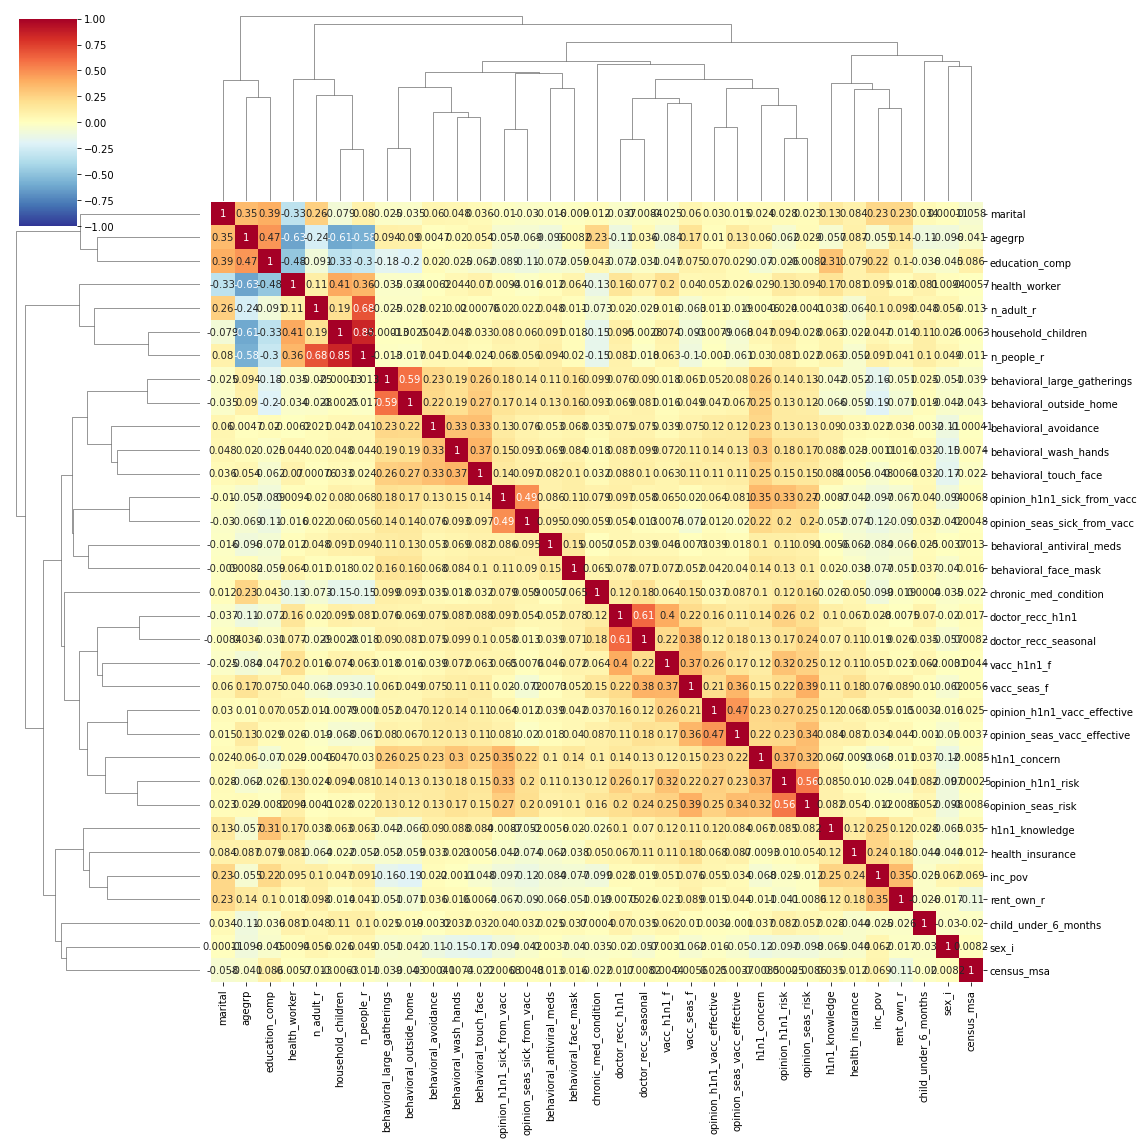

In [129]:
corr = df.corr(method='pearson')
sns.clustermap(corr, 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            figsize=(16,16)
            )

In [130]:
# n_adult_r + household_children = n_people_r
for i in range(len(df)):
    if np.isnan(df['n_adult_r'][i]) or np.isnan(df['household_children'][i]) or np.isnan(df['n_people_r'][i]):
        continue
    if df['n_adult_r'][i]+df['household_children'][i]!=df['n_people_r'][i]:
        print(f"{df['n_adult_r'][i]},{df['household_children'][i]},{df['n_people_r'][i]}")

##### Clustering

In [131]:
# one-hot encoder
def encoder(df,type_feature_temp):
    encode_needed = [x for x in df.columns if type_feature_temp[x]=='nominal']
    encoded = pd.get_dummies(df,columns=encode_needed)
    col_list = encoded.columns.tolist()
    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(',','_')
        col_list[i] = col_list[i].replace(' ','_')
    encoded.columns = col_list
    return encoded

In [132]:

# X shoudl be a numpy matrix, very likely sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix
# T1 > T2 for overlapping clusters
# T1 = Distance to centroid point to not include in other clusters
# T2 = Distance to centroid point to include in cluster
# T1 > T2 for overlapping clusters
# T1 < T2 will have points which reside in no clusters
# T1 == T2 will cause all points to reside in mutually exclusive clusters
# Distance metric can be any from here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html
# filemap may be a list of point names in their order in X. If included, row numbers from X will be replaced with names from filemap. 
 
def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

In [133]:
cnp=canopy(encoder(df[train.columns].dropna(),type_feature),9,5)
print(len(cnp))
print(cnp)

6
{0: {'c': 0, 'points': [0, 82, 236, 263, 304, 350, 360, 754, 786, 826, 1044, 1055, 1091, 1286, 1287, 1291, 1374, 1447, 1511, 1523, 1551, 1801, 1985, 2029, 2076, 2154, 2190, 2240, 2291, 2499, 2627, 2650, 2714, 2737, 2768, 2773, 2849, 2861, 2949, 2991, 3093, 3142, 3150, 3241, 3268, 3512, 3571, 3719, 3734, 3815, 3859, 3879, 4055, 4213, 4238, 4327, 4379, 4395, 4462, 4470, 4569, 4584, 4629, 4659, 4706, 4794, 4890, 4970, 4971, 5080, 5134, 5321, 5377, 5405, 5428, 5443, 5592, 5745, 5829, 5870, 5879, 6039, 6042, 6081, 6189, 6261, 6300, 6333, 6366, 6368, 6536, 6644, 6674, 6685, 6734, 6897, 6981, 7022, 7033, 7047, 7286, 7339, 7497, 7635, 7724, 7782, 7802, 7826, 8076, 8085, 8092, 8191, 8316, 8428, 8975, 9148, 9165]}, 1: {'c': 6148, 'points': [6148]}, 2: {'c': 3586, 'points': [208, 665, 900, 3031, 3586, 4898, 5113, 5164, 5529, 7284, 8693, 9215]}, 3: {'c': 256, 'points': [256, 6543]}, 4: {'c': 4612, 'points': [71, 159, 261, 368, 440, 744, 790, 996, 1100, 1383, 1496, 1652, 1675, 1790, 1866, 2338, 2

In [134]:
# set the number of clusters desired (in this example, 3)
K = 6
# use previously existing data to perform clustering
clustering_results = k_pod(encoder(df[train.columns],type_feature), K)
# k_pod outputs a tuple with the cluster assignments and centers
print(clustering_results)
# save the cluster assignments and centers
cluster_assignments = clustering_results[0]
cluster_centers = clustering_results[1]

(array([0., 5., 1., ..., 3., 5., 0.]), [array([8.31967276e-01, 9.11394443e-01, 1.28717732e-01, 5.03627653e-01,
       1.26306239e-01, 5.66888228e-01, 2.56521188e-01, 2.54416129e-01,
       4.68434142e-01, 2.91722561e-01, 3.21436991e-01, 1.29513983e-01,
       1.69677433e-01, 7.61788480e-01, 7.78769075e-01, 2.10740951e+00,
       1.05598546e+00, 1.31875477e+00, 2.05383700e+00, 1.13307429e+00,
       1.31204505e+00, 2.08488413e+00, 1.44442584e+00, 5.11148174e-01,
       2.22282857e+00, 1.37309059e-01, 7.51701664e-01, 1.01307935e+00,
       2.16702285e+00, 1.69624136e+00, 3.86610791e+00, 1.18591994e-01,
       8.73419944e-02, 8.95365169e-02, 7.04529494e-01, 1.48086376e-01,
       5.15273876e-02, 1.83462079e-02, 7.39115169e-01, 2.18750000e-01,
       1.62921348e-01, 3.38219803e-01, 2.80108848e-01, 8.07584270e-03,
       4.47682584e-03, 4.03792135e-03, 2.37008427e-03, 2.54564607e-03,
       1.83462079e-02, 1.20259831e-02, 6.75912921e-03, 1.96629213e-02,
       3.24789326e-03, 0.00000000e+00

In [135]:
(len(df), len(clustering_results[0]))

(42154, 42154)

In [136]:
# Cluster sampling
split_index = pd.DataFrame(clustering_results[0],columns=['cluster']).reset_index()
train_index = []
test_index = []
validate_index = []
for i in split_index.cluster.unique():
    X_temp,X_test,y_temp,y_test = train_test_split(split_index[split_index.cluster==i],split_index[split_index.cluster==i],test_size=0.2,random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.2,random_state=42)
    train_index.extend(X_train.index.tolist())
    test_index.extend(X_test.index.tolist())
    validate_index.extend(X_val.index.tolist())
len(train_index), len(test_index), len(validate_index)

(26974, 8434, 6746)

##### Factor analysis

In [137]:
# skip

##### Functionization

In [138]:
def EDA2(df):
    df = copy.deepcopy(df)
    student = (df['agegrp'] == 1) | (df['agegrp'] == 2)
    student_index = student[student==True].index
    df['health_worker'].loc[student_index]=df['health_worker'].loc[student_index].map(lambda x: x if not pd.isna(x) else 1)
    df['marital'].loc[student_index]=df['marital'].loc[student_index].map(lambda x: x if not pd.isna(x) else 0)
    df['education_comp'].loc[student_index]=df['education_comp'].loc[student_index].map(lambda x: x if not pd.isna(x) else 1)
    a=np.logical_and(df['employment_industry'].isna(),df['employment_occupation'].isna())
    df['employment_status'].loc[a[a==False].index] = df['employment_status'].loc[a[a==False].index].map(lambda x: 'Employed')
    df['employment_status'].loc[student_index]=df['employment_status'].loc[student_index].map(lambda x: x if not pd.isna(x) else 'student')
    df['employment_industry'].loc[student_index]=df['employment_industry'].loc[student_index].map(lambda x: x if not pd.isna(x) else 'student')
    df['employment_occupation'].loc[student_index]=df['employment_occupation'].loc[student_index].map(lambda x: x if not pd.isna(x) else 'student')
    a=df['employment_status'] =='Unemployed'
    a=a[a==True].index
    df['employment_occupation'].loc[a]=df['employment_occupation'].loc[a].map(lambda x: 'Unemployed')
    df['employment_industry'].loc[a]=df['employment_industry'].loc[a].map(lambda x: 'Unemployed')
    for i in range(len(df)):
        pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
        if np.isnan(pList).sum()==1:
            if np.isnan(pList[0]):
                df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
            elif np.isnan(pList[1]):
                df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
            else:
                df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
    clear_output()
    return df

## Data Preprocessing

### Duplicates

In [139]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
target = target['vacc_h1n1_f']
df=pd.concat([train,target],axis=1)

In [140]:
max_acc = (train.shape[0]-train.duplicated(keep=False).sum())/train.shape[0]*100
print(f'maximum accuracy from this data = {max_acc}%')

maximum accuracy from this data = 98.06424064145752%


In [141]:
duplicated = train.loc[train.duplicated(keep=False).tolist()].fillna(999)
dels=[]
Trues=[]
Falses=[]
for i in duplicated.drop_duplicates(keep='first').index:
    how_same_table = (duplicated == duplicated.loc[i])
    uniqs = (how_same_table.sum(axis=1) == len(duplicated.columns))
    uniqs_index = how_same_table.loc[uniqs].index.tolist()
    target_difference_rate = sum(df['vacc_h1n1_f'].loc[uniqs_index])/len(df['vacc_h1n1_f'].loc[uniqs_index])
    if target_difference_rate == 0.5:
        dels.append(uniqs_index)
    elif target_difference_rate > 0.5:
        Trues.append(uniqs_index)
    else:
        Falses.append(uniqs_index)
Trues=list(itertools.chain(*Trues))
df['vacc_h1n1_f'].loc[Trues]=np.ones(len(Trues))
Falses=list(itertools.chain(*Falses))
df['vacc_h1n1_f'].loc[Falses]=np.ones(len(Falses))
dels=list(itertools.chain(*dels))
df.drop(dels,inplace=True)
clear_output()

In [142]:
# duplicates
df.duplicated().sum()

330

In [143]:
# drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
train = df.drop(['vacc_h1n1_f'],axis=1)
target = df['vacc_h1n1_f']
df.duplicated().sum(), train.duplicated().sum()

(0, 0)

In [144]:
df.shape

(41610, 39)

In [145]:
def data_init():
    train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
    target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
    target = target['vacc_h1n1_f']
    df=pd.concat([train,target],axis=1)
    return train, target, df


In [146]:
def dupl(train,target):
    df=pd.concat([train,target],axis=1)
    duplicated = train.loc[train.duplicated(keep=False).tolist()].fillna('999')
    dels=[]
    Trues=[]
    Falses=[]
    for i in duplicated.drop_duplicates(keep='first').index:
        how_same_table = (duplicated == duplicated.loc[i])
        uniqs = (how_same_table.sum(axis=1) == len(duplicated.columns))
        uniqs_index = how_same_table.loc[uniqs].index.tolist()
        target_difference_rate = sum(df['vacc_h1n1_f'].loc[uniqs_index])/len(df['vacc_h1n1_f'].loc[uniqs_index])
        if target_difference_rate == 0.5:
            dels.append(uniqs_index)
        elif target_difference_rate > 0.5:
            Trues.append(uniqs_index)
        else:
            Falses.append(uniqs_index)
    Trues=list(itertools.chain(*Trues))
    df['vacc_h1n1_f'].loc[Trues]=np.ones(len(Trues))
    Falses=list(itertools.chain(*Falses))
    df['vacc_h1n1_f'].loc[Falses]=np.ones(len(Falses))
    dels=list(itertools.chain(*dels))
    df.drop(dels,inplace=True)
    df = df.drop_duplicates().reset_index(drop=True)
    train = df.drop(['vacc_h1n1_f'],axis=1)
    target = df['vacc_h1n1_f']
    clear_output()
    return train, target

### Type casting

In [147]:
def type_casting(df,type_feature_temp):
    df_temp = copy.deepcopy(df)
    for column in df_temp.columns:
        if type_feature_temp[column]=='bool':
            pass
        elif type_feature_temp[column]=='nominal':
            df_temp[column]=df_temp[column].astype('category')
        elif type_feature_temp[column]=='ordinal':
            df_temp[column]=df_temp[column].astype('float')
        elif type_feature_temp[column]=='ratio':
            df_temp[column]=df_temp[column].astype('float')
    return df_temp

### Baseline model

In [209]:
train, target,df = data_init()
train = EDA1(train)
train = EDA2(train)
train, target = dupl(train,target)
df = pd.concat((train,target),axis=1)
train = type_casting(train,type_feature)
X_train, X_test, y_train, y_test = train_test_split(train,target, test_size=0.2, random_state=42)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
clear_output()

In [149]:
def objective(trial):  # `trial` is an object passed by Optuna.
    '''
    Optuna objective function for tuning hyperparameter
    '''
    params = {
        'n_jobs' : -1,
        'n_estimators' : 500,
        'learning_rate' : 0.01,
        'silent' : -1,
        'verbose' : -1,
        'scale_pos_weight' : y_train.value_counts()[0]/y_train.value_counts()[1],
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf",1,30),
        'max_depth' : trial.suggest_int("max_depth",4,8),
        'num_leaves' : trial.suggest_int("num_leaves",16,256),
        'min_child_samples' : trial.suggest_int("min_child_samples",1,100),
        'min_child_weight' : trial.suggest_float("min_child_weight",1e-3,1,log=True),
        'reg_lambda' : trial.suggest_float("reg_lambda",1e-4,1e-3,log=True),
        'reg_alpha' : trial.suggest_float("reg_alpha",1e-3,1e-2,log=True)
    }
    losses = 0
    step = 1
    n_splits = 10
    kfold = StratifiedKFold(n_splits = n_splits)
    for train_index, val_index in kfold.split(X_train,y_train):
        X_t = X_train.iloc[train_index]
        y_t = y_train.iloc[train_index]
        X_v = X_train.iloc[val_index]
        y_v = y_train.iloc[val_index]
        lgb_model = LGBMClassifier(**params)
        lgb_model.fit(X_t, y_t, eval_set=[(X_t, y_t), (X_v, y_v)], eval_metric= 'f1', verbose = 0, early_stopping_rounds= 100)
        bce = BinaryCrossentropy()
        loss = bce(y_test,lgb_model.predict_proba(X_test)[:,1]).numpy()
        losses += loss
        trial.report(loss, step)
        if trial.should_prune():
            raise optuna.TrialPruned()
        step+=1
        
    losses = losses/n_splits
    clear_output()
    return losses
    
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [150]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(random_seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study.optimize(objective, n_trials=30)
clear_output()

In [151]:
print('Minimum objective value: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

Minimum objective value: 0.4537916658153104
Best parameter: {'min_data_in_leaf': 5, 'max_depth': 8, 'num_leaves': 181, 'min_child_samples': 50, 'min_child_weight': 0.0014707710561502523, 'reg_lambda': 0.00034231749878986924, 'reg_alpha': 0.0023586266737932004}


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=5
0.5834051105368935


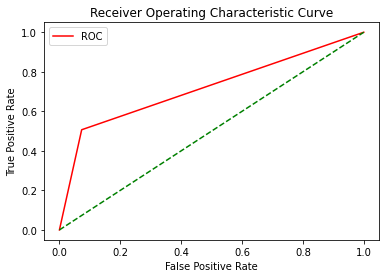

In [152]:
lgb_model = LGBMClassifier(**study.best_params)
lgb_model.fit(X_train,y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test)[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

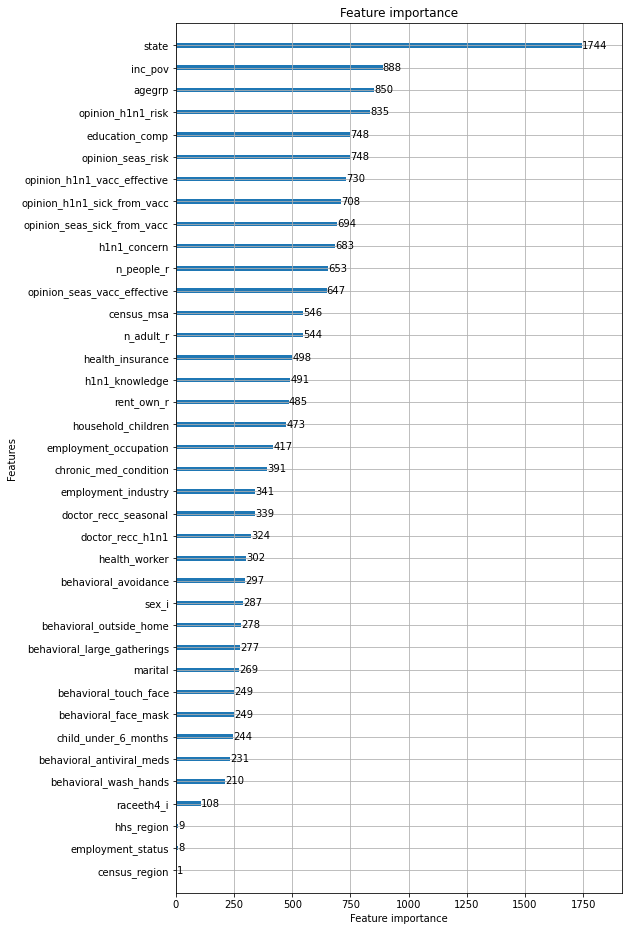

In [153]:
plot_importance(lgb_model,figsize=(8,16))

In [154]:
lgb_model = LGBMClassifier(**study.best_params)
lgb_model.fit(train,target, eval_metric = 'f1', verbose = 0)
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA1(test)
test = EDA2(test)
test_casted = type_casting(test,type_feature)
sub = list(map(round,lgb_model.predict_proba(test_casted)[:,1]))
submission=pd.DataFrame(sub,columns=['vacc_h1n1_f'])
submission.index.name='Id'
submission.to_csv('submission.csv')

- kaggle score : 0.57159

In [155]:
best_param = {'min_data_in_leaf': 1, 'max_depth': 8, 'num_leaves': 252, 'min_child_samples': 56, 'min_child_weight': 0.8149235713004346, 'reg_lambda': 0.00024325070512654304, 'reg_alpha': 0.0011639649878337978}

### Encoding

#### One Hot Encoding

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.5888824551244933


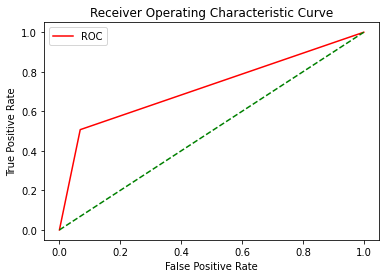

In [156]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(encoder(X_train,type_feature),y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(encoder(X_test,type_feature))[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

#### Catboost Encoding

In [157]:
CBE_encoder = CatBoostEncoder()
X_train_cbe = CBE_encoder.fit_transform(X_train, y_train,cols=[x for x in X_train.columns if type_feature[x]=='nominal'])
X_test_cbe = CBE_encoder.transform(X_test)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.5713434614238904


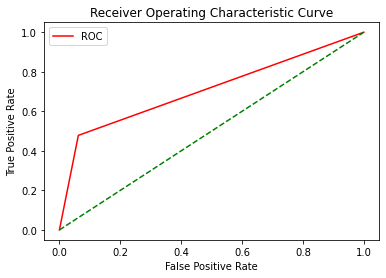

In [158]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train_cbe,y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test_cbe)[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

### Feature Engineering

#### Feature Selection

##### Filter method

- Information value

In [159]:
def iv_woe(data, target, bins=10):
    newDF = pd.DataFrame()
    cols = data.columns
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
    return newDF

In [160]:
iv = iv_woe(data = df, target = 'vacc_h1n1_f')

In [161]:
iv = iv.sort_values(by='IV',ascending=False)
iv.head(5)

Variable        IV
0             doctor_recc_h1n1  0.760833
0            opinion_h1n1_risk  0.603241
0  opinion_h1n1_vacc_effective  0.543598
0            opinion_seas_risk  0.396256
0          employment_industry  0.386283

In [162]:
f1_lst = []
for i in range(1,len(iv)+1):
    selected = iv.head(i)['Variable'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
iv_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

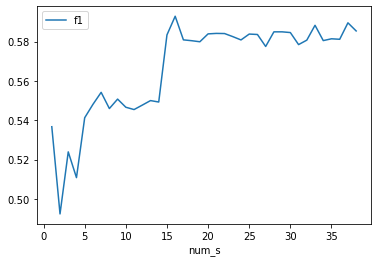

In [163]:
iv_res.plot(x='num_s',y='f1')

- custom filter

In [164]:
def custom_filter(train,df,type_feature):
    custom_u = []
    custom_c = []
    for column in train.columns:
        c_value=0
        for uniq in df[column].dropna().unique():
            tg1 = df[df['vacc_h1n1_f']==1]
            tg0 = df[df['vacc_h1n1_f']==0]
            tg1u = tg1[tg1[column]==uniq]
            tg0u = tg0[tg0[column]==uniq]
            u_value = abs(len(tg1u)/len(tg1)-len(tg0u)/len(tg0))*(len(tg1u)+len(tg0u))/len(df[column].dropna())
            c_value+=u_value
            if type_feature[column]=='nominal':
                custom_u.append([f'{column},{uniq}',u_value])
        custom_c.append([column,c_value])
    custom_u = pd.DataFrame(custom_u,columns=['name','value'])
    custom_c = pd.DataFrame(custom_c,columns=['col','value'])
    return custom_u, custom_c


In [165]:
custom_u, custom_c = custom_filter(X_train,df,type_feature)

In [166]:
custom_u.sort_values(by='value',ascending=False).head(10)

name     value
35                      employment_occupation,student  0.041245
12                        employment_industry,student  0.040936
5                          employment_status,Employed  0.030105
4                           employment_status,student  0.027503
11                                census_region,south  0.016065
6                employment_status,Not in Labor Force  0.011886
0                 raceeth4_i,Non-Hispanic, White Only  0.008311
25  employment_industry,Health Care and Social Ass...  0.007172
64                                 hhs_region,Region4  0.006265
10                            census_region,northeast  0.004824

In [167]:
custom_c = custom_c.sort_values(by='value',ascending=False)
custom_c.head(10)

col     value
9              doctor_recc_h1n1  0.358790
13             health_insurance  0.239028
14                health_worker  0.214058
10         doctor_recc_seasonal  0.206920
4          behavioral_face_mask  0.152614
2     behavioral_antiviral_meds  0.143876
16            opinion_h1n1_risk  0.143142
12         child_under_6_months  0.139050
15  opinion_h1n1_vacc_effective  0.133178
19            opinion_seas_risk  0.108253

In [168]:
f1_lst = []
for i in range(1,len(custom_c)+1):
    selected = custom_c.head(i)['col'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
cus_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

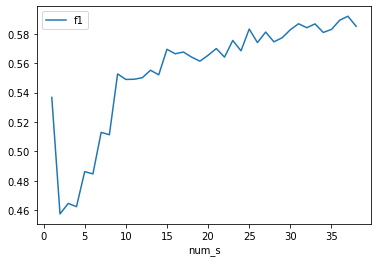

In [169]:
cus_res.plot(x='num_s',y='f1')

##### wrapper method

- Feature Importance

In [170]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train,y_train, eval_metric= 'f1', verbose = 0)
shap.initjs()
explainer = shap.TreeExplainer(lgb_model)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


In [171]:
pred = pd.Series(list(map(np.round,lgb_model.predict_proba(X_test)[:,1])))
p1_index = pred == 1
p0_index = pred == 0
a1_index = y_test == 1
a0_index = y_test == 0
tp_index = np.logical_and(p1_index,a1_index).tolist()
fp_index = np.logical_and(p1_index,a0_index).tolist()
tn_index = np.logical_and(p0_index,a0_index).tolist()
fn_index = np.logical_and(p0_index,a1_index).tolist()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


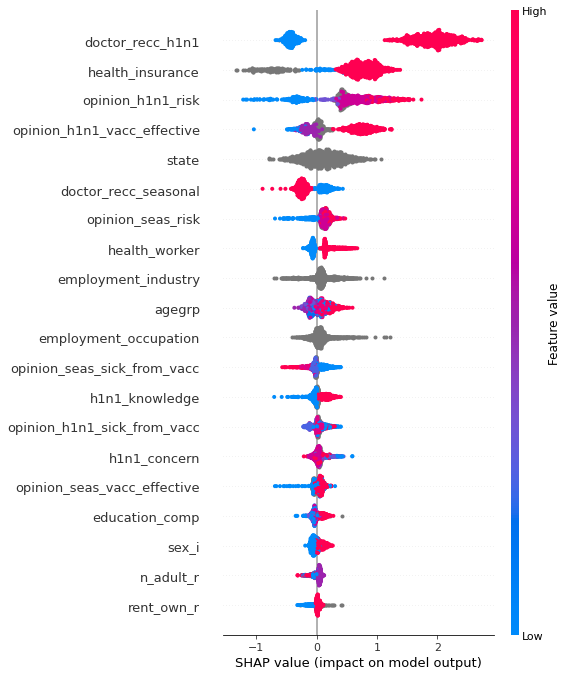

In [172]:
shap_values = explainer.shap_values(X_test.iloc[tp_index])
shap.summary_plot(shap_values[1], X_test.iloc[tp_index])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


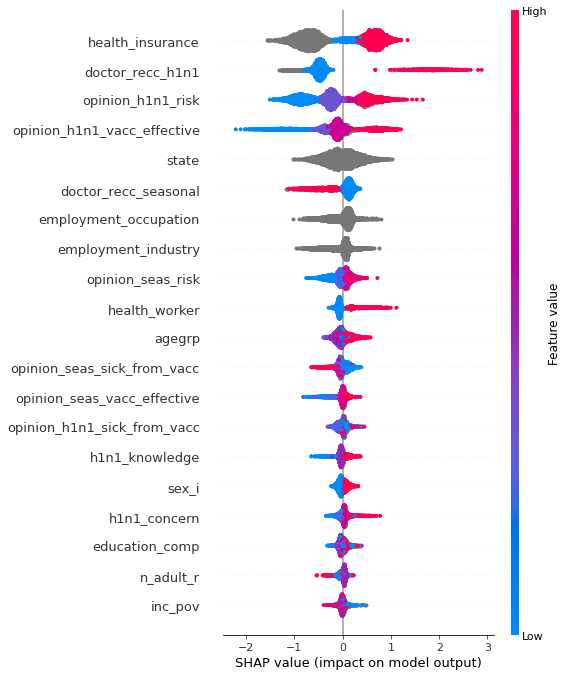

In [173]:
shap_values = explainer.shap_values(X_test.iloc[tn_index])
shap.summary_plot(shap_values[1], X_test.iloc[tn_index])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


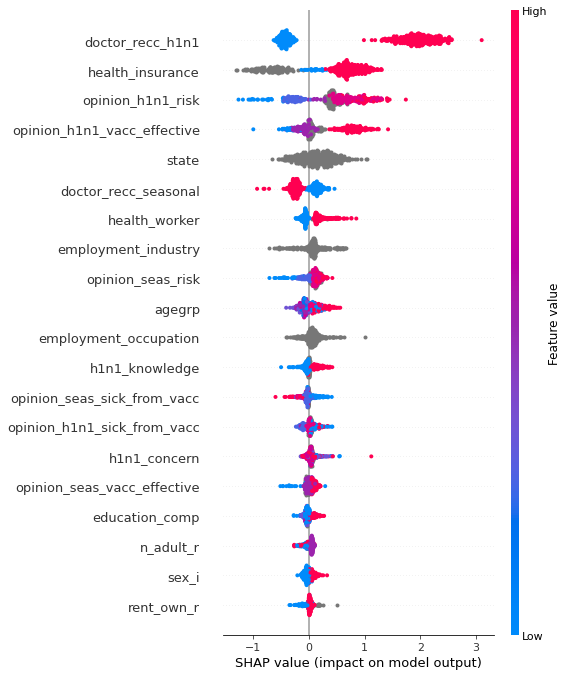

In [174]:
shap_values = explainer.shap_values(X_test.iloc[fp_index])
shap.summary_plot(shap_values[1], X_test.iloc[fp_index])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


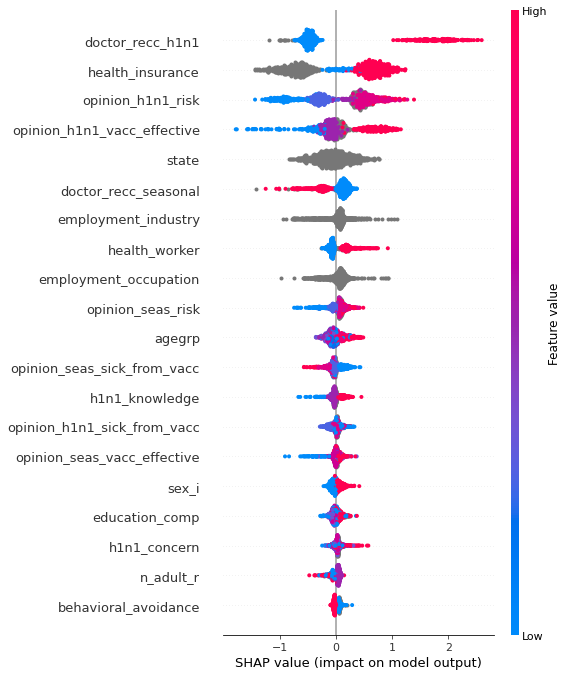

In [175]:
shap_values = explainer.shap_values(X_test.iloc[fn_index])
shap.summary_plot(shap_values[1], X_test.iloc[fn_index])

In [176]:
row = X_test.iloc[[23]]
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit'
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [177]:
f1_lst = []
for col in X_train.columns:
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train.drop(col,axis=1),y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test.drop(col,axis=1))[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([col,f1])
f_i = pd.DataFrame(f1_lst,columns=['dcol','f1'])
f_i = f_i.sort_values(by='f1')
clear_output()

In [178]:
f_i.head(10)

dcol        f1
9              doctor_recc_h1n1  0.516772
13             health_insurance  0.545663
16            opinion_h1n1_risk  0.561921
10         doctor_recc_seasonal  0.572989
15  opinion_h1n1_vacc_effective  0.576251
12         child_under_6_months  0.576613
18  opinion_seas_vacc_effective  0.578058
23                   raceeth4_i  0.578887
34          employment_industry  0.578992
22               education_comp  0.579295

In [179]:
f1_lst = []
for i in range(1,len(f_i)+1):
    selected = f_i.head(i)['dcol'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
fi_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

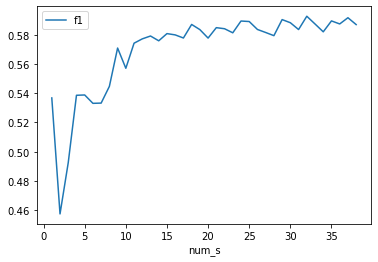

In [180]:
fi_res.plot(x='num_s',y='f1')

- Akaike Information Criterion

In [181]:
def all_aic(train,target):
    aic=[]
    for column in train.columns:
        x = train[column].dropna()
        y=target[x.index]
        model = Logit(np.array(y),np.array(sm.add_constant(x),dtype=float)).fit(method='bfgs')
        aic.append([column,model.aic,model.bic])
    return pd.DataFrame(aic,columns=['col','aic','bic'])

In [182]:
def label_encoder(df):
    data = copy.deepcopy(df)
    for col in [x for x in data.columns if type_feature[x]=='nominal']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    return data
X_train_le = label_encoder(X_train)

In [183]:
aic = all_aic(X_train_le,target)
aic = aic.sort_values(by=['aic'])
clear_output()

In [184]:
aic.head(10)

col           aic           bic
13             health_insurance  19889.585391  19905.177196
12         child_under_6_months  29106.847614  29123.193422
20  opinion_seas_sick_from_vacc  29482.685233  29499.053447
19            opinion_seas_risk  29510.910903  29527.280779
18  opinion_seas_vacc_effective  29567.458121  29583.832068
15  opinion_h1n1_vacc_effective  29616.278409  29632.656569
17  opinion_h1n1_sick_from_vacc  29641.500654  29657.880317
16            opinion_h1n1_risk  29642.055021  29658.434533
3          behavioral_avoidance  29820.093019  29836.485631
8         behavioral_touch_face  29914.906642  29931.304992

In [185]:
f1_lst = []
for i in range(1,len(aic)+1):
    selected = aic.head(i)['col'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
aic_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

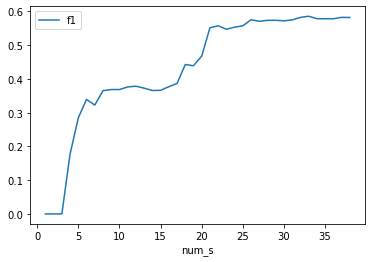

In [186]:
aic_res.plot(x='num_s',y='f1')

##### Result of Feature Selection

In [187]:
print(iv_res.sort_values(by='f1',ascending=False).head(1))
print(cus_res.sort_values(by='f1',ascending=False).head(1))
print(fi_res.sort_values(by='f1',ascending=False).head(1))
print(aic_res.sort_values(by='f1',ascending=False).head(1))

    num_s        f1
15     16  0.592867
    num_s        f1
36     37  0.592023
    num_s        f1
31     32  0.592593
    num_s        f1
32     33  0.585841


In [188]:
selected = iv.head(16)['Variable'].tolist()

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.592867332382311


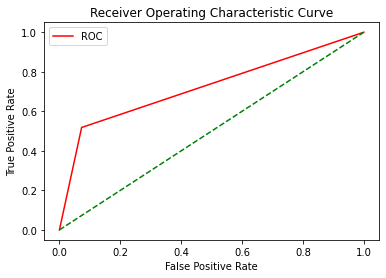

In [189]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test[selected])[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

In [190]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(train[selected],target, eval_metric= 'f1', verbose = 0)
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA1(test)
test = EDA2(test)
test_casted = type_casting(test,type_feature)
sub = list(map(round,lgb_model.predict_proba(test_casted[selected])[:,1]))
submission=pd.DataFrame(sub,columns=['vacc_h1n1_f'])
submission.index.name='Id'
submission.to_csv('submission.csv')

- kaggle score : 0.58015

In [191]:
dropcols = [x for x in X_train.columns if x not in selected]

#### Feature Extraction

In [251]:
def simple_train(X_train,y_train,X_test):
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train,y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    return f1

In [255]:
simple_train(X_train,y_train,X_test)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


0.5853379152348225

##### FE1 : ordinal -> nominal

In [253]:
def ont(type_feature):
    type_feature_temp = copy.deepcopy(type_feature)
    for i in type_feature_temp:
        if type_feature_temp[i]== 'ordinal':
            type_feature_temp[i]='nominal'
    return type_feature_temp

In [254]:
temp2 = ont(type_feature)
f1_fe1 = simple_train(type_casting(X_train,temp2),y_train,type_casting(X_test,temp2))
print(f'f1_fe1 : {f1_fe1}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe1 : 0.5841013824884793


##### FE2 : behavior score

In [256]:
# EDA issue 2 : behavior
def fe2(df, type_feature):
    '''
    behavior score : sum of behavior inquiries (weight = 1)
    '''
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['behavior_score'] = df_temp['behavioral_antiviral_meds']+df_temp['behavioral_avoidance']+df_temp['behavioral_face_mask']+df_temp['behavioral_wash_hands']+df_temp['behavioral_large_gatherings']+df_temp['behavioral_outside_home']+df_temp['behavioral_touch_face']
    type_feature_temp['behavior_score'] = 'ratio'
    return df_temp, type_feature_temp

In [257]:
temp1, temp2 = fe2(X_train,type_feature)
temp3, temp2 = fe2(X_test,type_feature)
f1_fe2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe2 : {f1_fe2}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe2 : 0.582300374747766


In [197]:
def fe2_2(df, type_feature,w1,w2,w3,w4,w5,w6,w7):
    '''
    behavior score : sum of behavior inquiries (weight = 1)
    '''
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['behavior_score'] = w1*df_temp['behavioral_antiviral_meds']+w2*df_temp['behavioral_avoidance']+w3*df_temp['behavioral_face_mask']+w4*df_temp['behavioral_wash_hands']+w5*df_temp['behavioral_large_gatherings']+w6*df_temp['behavioral_outside_home']+w7*df_temp['behavioral_touch_face']
    type_feature_temp['behavior_score'] = 'ratio'
    return df_temp, type_feature_temp

In [904]:
def find_weights(trial):  # `trial` is an object passed by Optuna.
    '''
    Optuna objective function for tuning hyperparameter
    '''
    
    w1 = trial.suggest_float("w1",0,1)
    w2 = trial.suggest_float("w2",0,1)
    w3 = trial.suggest_float("w3",0,1)
    w4 = trial.suggest_float("w4",0,1)
    w5 = trial.suggest_float("w5",0,1)
    w6 = trial.suggest_float("w6",0,1)
    w7 = trial.suggest_float("w7",0,1)
        
    train_, type_feature_ = fe2_2(X_train, type_feature,w1,w2,w3,w4,w5,w6,w7)
    test_, type_feature_ = fe2_2(X_test,type_feature,w1,w2,w3,w4,w5,w6,w7)
    f1 = simple_train(type_casting(train_,type_feature_), y_train, type_casting(test_,type_feature_))
    clear_output()
    return f1

In [909]:
study2 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(random_seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study2.optimize(find_weights, n_trials=30)
clear_output()

In [910]:
print('Minimum objective value: ' + str(study2.best_value))
print('Best parameter: ' + str(study2.best_params))

Minimum objective value: 0.6084425036390101
Best parameter: {'w1': 0.9855485051544729, 'w2': 0.046315266092896504, 'w3': 0.28684552887424286, 'w4': 0.2564707022128156, 'w5': 0.8293173710706446, 'w6': 0.7620652481112213, 'w7': 0.9679814718811517}


In [198]:
weights={
    'w1': 0.9855485051544729, 
    'w2': 0.046315266092896504, 
    'w3': 0.28684552887424286, 
    'w4': 0.2564707022128156, 
    'w5': 0.8293173710706446, 
    'w6': 0.7620652481112213, 
    'w7': 0.9679814718811517
    }

In [258]:
temp1, temp2 = fe2_2(X_train,type_feature,**weights)
temp3, temp2 = fe2_2(X_test,type_feature,**weights)
f1_fe2_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe2_2 : {f1_fe2_2}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe2_2 : 0.5890097309673727


##### FE3 : high cardinality

In [200]:
def logic_and(arr1,arr2):
    na1 = pd.isna(arr1)
    na2 = pd.isna(arr2)
    na = np.logical_and(na1,na2)
    res = np.logical_and(arr1,arr2)
    return list(map(lambda x: np.nan if x[1] else res[x[0]],enumerate(na)))
def logic_or(arr1,arr2):
    na1 = pd.isna(arr1)
    na2 = pd.isna(arr2)
    na = np.logical_or(na1,na2)
    res = np.logical_or(arr1,arr2)
    return list(map(lambda x: np.nan if x[1] else res[x[0]],enumerate(na)))
def logic_xor(arr1,arr2):
    na1 = pd.isna(arr1)
    na2 = pd.isna(arr2)
    na = np.logical_xor(na1,na2)
    res = np.logical_xor(arr1,arr2)
    return list(map(lambda x: np.nan if x[1] else res[x[0]],enumerate(na)))


In [259]:
# EDA issue 3 : high cardinality
def fe3(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    hicar = [x for x in ['state','employment_occupation','employment_industry'] if x not in dropcols]
    df_temp.drop(hicar,axis=1,inplace=True)
    return df_temp, type_feature_temp

In [260]:
temp1, temp2 = fe3(X_train,type_feature)
temp3, temp2 = fe3(X_test,type_feature)
f1_fe3 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe3 : {f1_fe3}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe3 : 0.5877598152424941


##### FE4 : cluster

In [203]:
# EDA issue 4 : cluster
def fe4(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['cluster'] = clustering_results[0]
    type_feature_temp['cluster'] = 'nominal'

    return df_temp, type_feature_temp

##### FE5 : Imbalanced target

- Under sampling

In [261]:
# EDA issue 5 : Imbalanced target
def fe5(train,target):
    n = len(target[target==1])
    a=np.array(train.iloc[target[target==0].index].sample(n,random_state=42,axis=0).index)
    b=np.array(target[target==1].index)
    return np.concatenate((a,b))

In [262]:
index = fe5(X_train.reset_index(drop=True),y_train.reset_index(drop=True))
f1_fe5 = simple_train(X_train.iloc[index].reset_index(drop=True),y_train.iloc[index].reset_index(drop=True),X_test)
print(f'f1_fe5 : {f1_fe5}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe5 : 0.5978804239152169


- SMOTE

##### FE7 : logical combination

In [212]:
# feature extract using iteration
def ex_test(train,target,type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    bins=10

    newDF = pd.DataFrame()

    bin_cols=[]
    for column in train_temp.columns:
        if len(train_temp[column].dropna().unique()) == 2:
            bin_cols.append(column)
    df_bin = train_temp[bin_cols]
    for col1, col2 in itertools.combinations(df_bin.columns,2):
        df_bin_temp = df_bin[[col1,col2]]
        df_lo = pd.DataFrame()

        na1 = pd.isna(df_bin_temp[col1])
        na2 = pd.isna(df_bin_temp[col2])
        na_and = np.logical_and(na1,na2)
        na_or = np.logical_or(na1,na2)
        logand = np.logical_and(df_bin_temp[col1],df_bin_temp[col2])
        logor = np.logical_or(df_bin_temp[col1],df_bin_temp[col2])
        logxor = np.logical_xor(df_bin_temp[col1],df_bin_temp[col2])

        df_lo['and'] = list(map(lambda x: np.nan if x[1] else logand[x[0]],enumerate(na_or)))
        df_lo['or'] = list(map(lambda x: np.nan if x[1] else logor[x[0]],enumerate(na_and)))
        df_lo['xor'] = list(map(lambda x: np.nan if x[1] else logxor[x[0]],enumerate(na_or)))
        for lovar in df_lo.columns:
            d0 = pd.DataFrame({'x': df_lo[lovar], 'y': target['vacc_h1n1_f'].iloc[df_bin_temp.index]})
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
            d['Non-Events'] = d['N'] - d['Events']
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            print(f'{col1}_{lovar}_{col2}',d['IV'].sum())
            if d['IV'].sum()>0.6:
                temp =pd.DataFrame([[f'{col1}_{lovar}_{col2}',d['IV'].sum()]], columns = ["Variable", "IV"])
                newDF=pd.concat([newDF,temp], axis=0)
    return newDF


In [1013]:
a=ex_test(encoder(type_casting(train,type_feature,),type_feature),target,type_feature)

behavioral_antiviral_meds_and_behavioral_avoidance 0.007360977246618094
behavioral_antiviral_meds_or_behavioral_avoidance 0.012968034085142915
behavioral_antiviral_meds_xor_behavioral_avoidance 0.004632260928751225
behavioral_antiviral_meds_and_behavioral_face_mask 0.005272834602532347
behavioral_antiviral_meds_or_behavioral_face_mask 0.03589817563484668
behavioral_antiviral_meds_xor_behavioral_face_mask 0.028332217677159988
behavioral_antiviral_meds_and_behavioral_wash_hands 0.01207382103944573
behavioral_antiviral_meds_or_behavioral_wash_hands 0.03537946961200636
behavioral_antiviral_meds_xor_behavioral_wash_hands 0.010998309930800044
behavioral_antiviral_meds_and_behavioral_large_gatherings 0.005483302391961146
behavioral_antiviral_meds_or_behavioral_large_gatherings 0.004806456502935489
behavioral_antiviral_meds_xor_behavioral_large_gatherings 0.0015350355874915156
behavioral_antiviral_meds_and_behavioral_outside_home 0.004707314785287994
behavioral_antiviral_meds_or_behavioral_out

- all results include 'doctor_recc_h1n1'

In [1020]:
# IV of doctor_recc_h1n1 : 0.791771
a[a['IV']>0.6].sort_values(by='IV',ascending=False).head(10)

Variable        IV
0              doctor_recc_h1n1_and_health_insurance  0.794322
0  doctor_recc_h1n1_xor_employment_industry_Manag...  0.792328
0  doctor_recc_h1n1_xor_employment_industry_Armed...  0.791373
0  doctor_recc_h1n1_xor_employment_occupation_Mil...  0.791197
0  doctor_recc_h1n1_xor_opinion_h1n1_sick_from_va...  0.787907
0     doctor_recc_h1n1_xor_opinion_seas_risk_Refused  0.787119
0  doctor_recc_h1n1_xor_opinion_seas_sick_from_va...  0.786809
0     doctor_recc_h1n1_xor_opinion_h1n1_risk_Refused  0.786547
0  doctor_recc_h1n1_xor_opinion_seas_vacc_effecti...  0.785496
0  doctor_recc_h1n1_xor_opinion_h1n1_vacc_effecti...  0.781353

In [ ]:
# result1
['doctor_recc_h1n1_or_employment_occupation_Healthcare_Practitioners_and_Technical_Occupations',
 'doctor_recc_h1n1_or_opinion_h1n1_risk_Very_High',
 'doctor_recc_h1n1_or_employment_industry_Armed_Forces',
 'doctor_recc_h1n1_or_employment_occupation_Military_Specific_Occupations',
 'doctor_recc_h1n1_xor_employment_industry_Management_of_Companies_and_Enterprises_Industries',
 'doctor_recc_h1n1_or_employment_industry_Management_of_Companies_and_Enterprises_Industries']

In [1016]:
# result2
['doctor_recc_h1n1_and_health_insurance',
 'doctor_recc_h1n1_xor_employment_industry_Management_of_Companies_and_Enterprises_Industries']

['doctor_recc_h1n1_and_health_insurance',
 'doctor_recc_h1n1_xor_employment_industry_Management_of_Companies_and_Enterprises_Industries']

- doctor_recc_h1n1_or_employment_occupation_Healthcare

In [213]:
def fe7(train,type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    a = train_temp['doctor_recc_h1n1'].tolist()
    b = train_temp['employment_industry'].map(lambda x: True if x == 'Management of Companies and Enterprises Industries' else (np.nan if pd.isna(x) else False)).tolist()
    na1 = pd.isna(a)
    na2 = pd.isna(b)
    na_or = np.logical_or(na1,na2)
    logand = np.logical_and(a,b)
    train_temp['logires'] = list(map(lambda x: np.nan if x[1] else logand[x[0]],enumerate(na_or)))
    train_temp['logires'] = train_temp['logires'].astype('float')
    type_feature_temp['logires'] = 'bool'
    return train_temp, type_feature_temp

In [263]:
temp1, temp2 = fe7(X_train,type_feature)
temp3, temp2 = fe7(X_test,type_feature)
f1_fe7 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe7 : {f1_fe7}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe7 : 0.5841470419299254


In [215]:
def fe7_2(train,type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    a = train_temp['employment_occupation'] =='Healthcare Practitioners and Technical Occupations'
    b = train_temp['employment_industry'] =='Health Care and Social Assistance Industries'
    c = (a|b).tolist()
    train_temp['DRHor'] = train_temp['doctor_recc_h1n1']+c
    train_temp['DRHor'] = train_temp['DRHor'].map(lambda x: 1 if not pd.isna(x) else x)
    train_temp['DRHor'] = train_temp['DRHor'].astype('float')
    type_feature_temp['DRHor'] = 'bool'
    return train_temp, type_feature_temp

In [264]:
temp1, temp2 = fe7_2(X_train,type_feature)
temp3, temp2 = fe7_2(X_test,type_feature)
f1_fe7_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe7_2 : {f1_fe7_2}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe7_2 : 0.5853379152348225


##### FE8 : household children

In [217]:
def fe8(train, type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    train_temp['household_children'] = train_temp['household_children'].map(lambda x: False if x==0 else (np.nan if pd.isna(x) else True))
    train_temp['household_children'] = train_temp['household_children'].astype('float')
    type_feature_temp['household_children'] = 'bool'
    return train_temp, type_feature_temp

In [265]:
temp1, temp2 = fe8(X_train,type_feature)
temp3, temp2 = fe8(X_test,type_feature)
f1_fe8 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe8 : {f1_fe8}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe8 : 0.5844118492953695


### Missing Value Imputation

In [229]:
X_train_encoded = copy.deepcopy(X_train)
X_test_encoded = copy.deepcopy(X_test)
for col in [x for x in X_train_encoded.columns if type_feature[x]=='nominal']:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = le.transform(X_test_encoded[col])

In [230]:
def simple_train(X_train,y_train,X_test):
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train,y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    return f1

In [267]:
simple_train(X_train_encoded,y_train,X_test_encoded)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


0.5896621426508808

#### listwise deletion

In [232]:
ldf1 = simple_train(X_train.dropna(),y_train.loc[X_train.dropna().index],X_test)
print(f'ldf1 : {ldf1}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
ldf1 : 0.4737484737484738


#### median imputation

In [236]:
from sklearn.impute import SimpleImputer
medimp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_medimp = medimp.fit_transform(X_train_encoded)
X_test_medimp = medimp.transform(X_test_encoded)
medimputed = simple_train(X_train_medimp,y_train,X_test_medimp)
print(f'medimputed : {medimputed}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
medimputed : 0.5481823427582228


#### mean imputation

In [237]:
meanimp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_meanimp = meanimp.fit_transform(X_train_encoded)
X_test_meanimp = meanimp.transform(X_test_encoded)
meanimputed = simple_train(X_train_meanimp,y_train,X_test_meanimp)
print(f'meanimputed : {meanimputed}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
meanimputed : 0.593991416309013


#### most freq imputation

In [238]:
mfimp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_mfimp = mfimp.fit_transform(X_train_encoded)
X_test_mfimp = mfimp.transform(X_test_encoded)
mfimputed = simple_train(X_train_mfimp,y_train,X_test_mfimp)
print(f'mfimputed : {mfimputed}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
mfimputed : 0.5498261877172654


#### knn imputation

In [239]:
from sklearn.impute import KNNImputer
knnimp = KNNImputer(missing_values=np.nan, n_neighbors=6)
X_train_knnimp = knnimp.fit_transform(X_train_encoded)
X_test_knnimp = knnimp.transform(X_test_encoded)
knnimputed = simple_train(X_train_knnimp,y_train,X_test_knnimp)
print(f'knnimputed : {knnimputed}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
knnimputed : 0.5534843705190708


#### bayesian regressor multiple imputation

In [243]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
brmulimp = IterativeImputer(missing_values = np.nan, imputation_order = 'ascending', max_iter=10, random_state=42)
X_train_brmulimp = brmulimp.fit_transform(X_train_encoded)
X_test_brmulimp = brmulimp.transform(X_test_encoded)
brmulimputed = simple_train(X_train_brmulimp,y_train,X_test_brmulimp)
print(f'brmulimputed : {brmulimputed}')


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
brmulimputed : 0.5812263876780006


#### pmm, bbl imputation

In [195]:
import autoimpute

In [196]:
X_train_encoded = copy.deepcopy(X_train)
X_test_encoded = copy.deepcopy(X_test)
for col in [x for x in X_train_encoded.columns if type_feature[x]=='nominal']:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = le.transform(X_test_encoded[col])

In [198]:
strategy={}
for column in X_train_encoded[selected].columns:
    if len(X_train_encoded[selected][column].dropna().unique())==2:
        strategy[column]='bayesian binary logistic'
    else:
        strategy[column]='pmm'
strategy

{'doctor_recc_h1n1': 'bayesian binary logistic',
 'opinion_h1n1_risk': 'pmm',
 'opinion_h1n1_vacc_effective': 'pmm',
 'opinion_seas_risk': 'pmm',
 'employment_industry': 'pmm',
 'employment_occupation': 'pmm',
 'opinion_seas_vacc_effective': 'pmm',
 'health_worker': 'bayesian binary logistic',
 'doctor_recc_seasonal': 'bayesian binary logistic',
 'agegrp': 'pmm',
 'employment_status': 'pmm',
 'h1n1_knowledge': 'pmm',
 'h1n1_concern': 'pmm',
 'education_comp': 'pmm',
 'health_insurance': 'bayesian binary logistic',
 'state': 'pmm'}

In [197]:
selected_dependency = {}
for i in selected:
    selected_dependency[i]=[x for x in dependency[i] if x in selected]
selected_dependency

{'doctor_recc_h1n1': ['doctor_recc_seasonal',
  'health_insurance',
  'health_worker',
  'employment_status',
  'employment_industry',
  'employment_occupation',
  'state'],
 'opinion_h1n1_risk': ['h1n1_concern',
  'h1n1_knowledge',
  'opinion_h1n1_vacc_effective',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'agegrp',
  'education_comp'],
 'opinion_h1n1_vacc_effective': ['h1n1_concern',
  'h1n1_knowledge',
  'opinion_h1n1_risk',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'agegrp',
  'education_comp'],
 'opinion_seas_risk': ['h1n1_concern',
  'h1n1_knowledge',
  'opinion_h1n1_vacc_effective',
  'opinion_h1n1_risk',
  'opinion_seas_vacc_effective',
  'agegrp',
  'education_comp'],
 'employment_industry': ['doctor_recc_h1n1',
  'doctor_recc_seasonal',
  'health_insurance',
  'health_worker',
  'agegrp',
  'employment_status',
  'employment_occupation',
  'state'],
 'employment_occupation': ['doctor_recc_h1n1',
  'doctor_recc_seasonal',
  'health_insurance',
  

In [199]:
imp=autoimpute.imputations.SingleImputer(strategy=strategy, predictors=selected_dependency, imp_kwgs=None, copy=True, seed=None, visit='default')

In [200]:
imputed = imp.fit_transform(X_train_encoded,y_train)

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
divide by zero encountered in log
invalid value encountered in multiply
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


#### Multiple imputation

In [197]:
X_train_encoded = copy.deepcopy(X_train)
X_test_encoded = copy.deepcopy(X_test)
for col in [x for x in X_train_encoded.columns if type_feature[x]=='nominal']:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = le.transform(X_test_encoded[col])

In [199]:

strategy={}
for column in X_train_encoded[selected].columns:
    if len(X_train_encoded[selected][column].dropna().unique())==2:
        strategy[column]='bayesian binary logistic'
    else:
        strategy[column]='pmm'
strategy


{'doctor_recc_h1n1': 'bayesian binary logistic',
 'opinion_h1n1_risk': 'pmm',
 'opinion_h1n1_vacc_effective': 'pmm',
 'opinion_seas_risk': 'pmm',
 'employment_industry': 'pmm',
 'employment_occupation': 'pmm',
 'opinion_seas_vacc_effective': 'pmm',
 'health_worker': 'bayesian binary logistic',
 'doctor_recc_seasonal': 'bayesian binary logistic',
 'agegrp': 'pmm',
 'employment_status': 'pmm',
 'h1n1_knowledge': 'pmm',
 'h1n1_concern': 'pmm',
 'education_comp': 'pmm',
 'health_insurance': 'bayesian binary logistic',
 'state': 'pmm',
 'household_children': 'pmm',
 'opinion_h1n1_sick_from_vacc': 'pmm',
 'n_people_r': 'pmm',
 'behavioral_wash_hands': 'bayesian binary logistic'}

In [206]:
selected_dependency = {}
for i in selected:
    selected_dependency[i]=[x for x in dependency[i] if x in selected]
selected_dependency

{'doctor_recc_h1n1': ['behavioral_wash_hands',
  'doctor_recc_seasonal',
  'health_insurance',
  'health_worker',
  'employment_status',
  'household_children',
  'n_people_r',
  'employment_industry',
  'employment_occupation',
  'state'],
 'opinion_h1n1_risk': ['h1n1_concern',
  'h1n1_knowledge',
  'opinion_h1n1_vacc_effective',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'agegrp',
  'education_comp',
  'household_children',
  'n_people_r'],
 'opinion_h1n1_vacc_effective': ['h1n1_concern',
  'h1n1_knowledge',
  'opinion_h1n1_risk',
  'opinion_h1n1_sick_from_vacc',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'agegrp',
  'education_comp',
  'household_children',
  'n_people_r'],
 'opinion_seas_risk': ['h1n1_concern',
  'h1n1_knowledge',
  'opinion_h1n1_vacc_effective',
  'opinion_h1n1_risk',
  'opinion_h1n1_sick_from_vacc',
  'opinion_seas_vacc_effective',
  'agegrp',
  'education_comp',
  'household_children',
  'n_people_r'],
 'employment_industry': ['beha

In [208]:
imp = MiceImputer(
    k=3,
    n=5,
    strategy=strategy, 
    imp_kwgs={"pmm": {"fill_value": "random",'neighbors':6}}, 
    predictors=selected_dependency,
    visit="left-to-right", 
    return_list=True,
    seed=random_seed
    )
df_imputed=imp.fit_transform(X_train_encoded[selected])

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
divide by zero encountered in log
invalid value encountered in multiply
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

## XGBOOST & Grid search

In [266]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
params = {
    n_estimators : 1000,
    learning_rate : 0.01,
    verbosity : 100,
    objective :,
    n_jobs :-1,
    random_state :42,
    grow_policy :1,
    scale_pos_weight :
    max_depth : range(4,10).
    max_leaves : range(15,1023)

}
xgb = XGBClassifier(n_estimators =1000, )
gscv = GridSearchCV(xgb,params,scoring='f1',n_jobs=-1,cv=10)
gscv.fit(X, y, *, sample_weight=None, base_margin=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, base_margin_eval_set=None, feature_weights=None, callbacks=None)


## Output

In [ ]:
pred = clf.predict_proba(encoder(test,type_feature))
first_pred=pd.DataFrame(map(round,pred[:,1]),columns=['vacc_h1n1_f'])
first_pred.index.name='Id'
first_pred.to_csv('first_pred.csv')

In [ ]:
pred = clf.predict_proba(encoder(test,type_feature))
first_pred=pd.DataFrame(map(round,pred[:,1]),columns=['vacc_h1n1_f'])
first_pred.index.name='Id'
first_pred.to_csv('first_pred.csv')